In [1]:
# import packages
import pandas as pd
pd.set_option('display.max_columns', None)
import os
import glob
import random
import numpy as np
from functools import reduce
import statistics
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams # pip install matplotlib==3.4.2
import matplotlib.patches as mpatches
from pylab import *

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm

## Data Prep

In [2]:
path = r'/Users/spencersu/Desktop/JCPS external data mapping/'
intnl = pd.read_csv(os.path.join(path, 'JCPS internal 20-22.csv')) #670,813 rows × 25 columns
extnl_20_21 = pd.read_csv(os.path.join(path, 'asmt_performance_by_grade_2021.csv'))
extnl_21_22 = pd.read_csv(os.path.join(path, 'asmt_performance_by_grade_2022.csv'))
ncesid = pd.read_csv(os.path.join(path, 'JeffCo NCES ID.csv')) #171 records

### 1. Basic Data Overview

In [3]:
## Basic Data Overview

## num unique records with scores in extnl
# print(extnl_20_21.dropna(subset=['NOVICE','NCES ID'])['NCES ID'].nunique()) #1,081 schools in total
# print(extnl_20_21[extnl_20_21['DISTRICT NAME'].str.startswith('Jefferson')]) # JeffCo district number is 275, #3,987 records 

## select only JeffCo records
extnl_20_21 = extnl_20_21[extnl_20_21['DISTRICT NUMBER']==275]
extnl_21_22 = extnl_21_22[extnl_21_22['DISTRICT NUMBER']==275]

## extnl: num schools in JeffCo 
print('extnl - num schools unsupressed in 20-21: ',extnl_20_21[extnl_20_21['SUPPRESSED'] != "Y"]['SCHOOL NAME'].nunique()) 
print('extnl - num schools unsupressed in 21-22: ',extnl_21_22[extnl_21_22['SUPPRESSED'] != "Y"]['SCHOOL NAME'].nunique(), '\n')

print('extnl - num schools unsupressed in 20-21 by subject: \n',extnl_20_21[extnl_20_21['SUPPRESSED'] != "Y"].groupby('SUBJECT')['SCHOOL NAME'].nunique(), '\n')
print('extnl - num schools unsupressed in 21-22 by subject: \n',extnl_21_22[extnl_21_22['SUPPRESSED'] != "Y"].groupby('SUBJECT')['SCHOOL NAME'].nunique(), '\n')

print('extnl - num records unsupressed in 20-21 by subject: \n',extnl_20_21[(extnl_20_21['SUPPRESSED'] != "Y") & (extnl_20_21['DEMOGRAPHIC']=='All Students')].groupby('SUBJECT')['SCHOOL NAME'].count(), '\n')
print('extnl - num records unsupressed in 21-22 by subject: \n',extnl_21_22[(extnl_21_22['SUPPRESSED'] != "Y") & (extnl_21_22['DEMOGRAPHIC']=='All Students')].groupby('SUBJECT')['SCHOOL NAME'].count(), '\n')

print('extnl - num schools unsupressed in 20-21 by subject and grade: \n',extnl_20_21[extnl_20_21['SUPPRESSED'] != "Y"].groupby(['SUBJECT','GRADE'])['SCHOOL NAME'].nunique(), '\n')
# extnl_20_21[extnl_20_21['SUPPRESSED'] != "Y"].groupby(['SUBJECT','GRADE'])['SCHOOL NAME'].nunique().reset_index().to_csv(os.path.join(path, 'num_schools_by_subject_grade_20-21.csv'))
print('extnl - num schools unsupressed in 21-22 by subject and grade: \n',extnl_21_22[extnl_21_22['SUPPRESSED'] != "Y"].groupby(['SUBJECT','GRADE'])['SCHOOL NAME'].nunique(), '\n')
# extnl_21_22[extnl_21_22['SUPPRESSED'] != "Y"].groupby(['SUBJECT','GRADE'])['SCHOOL NAME'].nunique().reset_index().to_csv(os.path.join(path, 'num_schools_by_subject_grade_21-22.csv'))

extnl - num schools unsupressed in 20-21:  113
extnl - num schools unsupressed in 21-22:  139 

extnl - num schools unsupressed in 20-21 by subject: 
 SUBJECT
MA     58
RD    112
SC     27
WR     61
Name: SCHOOL NAME, dtype: int64 

extnl - num schools unsupressed in 21-22 by subject: 
 SUBJECT
EM    134
MA    128
RD    138
SC     75
SS    125
WR    101
Name: SCHOOL NAME, dtype: int64 

extnl - num records unsupressed in 20-21 by subject: 
 SUBJECT
MA    117
RD    249
SC     29
WR     63
Name: SCHOOL NAME, dtype: int64 

extnl - num records unsupressed in 21-22 by subject: 
 SUBJECT
EM    142
MA    296
RD    365
SC     75
SS    133
WR    103
Name: SCHOOL NAME, dtype: int64 

extnl - num schools unsupressed in 20-21 by subject and grade: 
 SUBJECT  GRADE
MA       3        22
         4        25
         5        28
         6        10
         7        11
         8        11
         10       10
RD       3        42
         4        54
         5        60
         6        23
     

In [4]:
## remove all the unsubmitted work
intnl_sbmt_grd = intnl[~(intnl['Student Assignment Status'].isin(['not_started','in_progress','needs_revision']))]

## intnl: num schools
print('intnl - total num schools: \n', intnl.groupby('School Year')['School Id'].nunique(), '\n') 

print('intnl - num schools w/ submitted asmts: \n',intnl_sbmt_grd.groupby('School Year')['School Id'].nunique(), '\n')

print('intnl - num schools w/ graded asmts: \n',intnl_sbmt_grd[intnl_sbmt_grd['Student Assignment Status']=='graded'].groupby('School Year')['School Id'].nunique(), '\n')

print('intnl - num schools w/ submitted asmts by lesson type: \n',intnl_sbmt_grd.groupby(['School Year','Lesson Type'])['School Id'].nunique(), '\n')

print('intnl - num schools w/ graded asmts by lesson type: \n',intnl_sbmt_grd[intnl_sbmt_grd['Student Assignment Status']=='graded'].groupby(['School Year','Lesson Type'])['School Id'].nunique(), '\n')


intnl - total num schools: 
 School Year
2020-2021    136
2021-2022    142
Name: School Id, dtype: int64 

intnl - num schools w/ submitted asmts: 
 School Year
2020-2021    120
2021-2022    109
Name: School Id, dtype: int64 

intnl - num schools w/ graded asmts: 
 School Year
2020-2021    92
2021-2022    70
Name: School Id, dtype: int64 

intnl - num schools w/ submitted asmts by lesson type: 
 School Year  Lesson Type                 
2020-2021    Benchmark - Baseline Writing     70
             Benchmark - End-of-Year          27
             Benchmark - Leveling             29
             Benchmark - Mid-Year             55
             Custom Lesson                     6
             Direct Instruction              106
             Reading Practice                 43
             Skills Lesson                    84
             Writing Lesson                   98
2021-2022    Benchmark - Baseline Writing     54
             Benchmark - End-of-Year          41
             Benchma

In [5]:
## total num of asmts
print('intnl - total num asmts: \n',intnl.groupby('School Year')['Student Assignment Id'].nunique(), '\n')

## num of submitted and graded asmts
print('intnl - num submitted asmts: \n',intnl_sbmt_grd.groupby('School Year')['Student Assignment Id'].nunique(), '\n')
print('intnl - num graded asmts: \n',intnl_sbmt_grd[intnl_sbmt_grd['Student Assignment Status']=='graded'].groupby('School Year')['Student Assignment Id'].nunique(), '\n')
print('intnl - num submitted asmts by lesson type: \n',intnl_sbmt_grd.groupby(['School Year','Lesson Type'])['Student Assignment Id'].nunique(), '\n')
print('intnl - num graded asmts by lesson type: \n',intnl_sbmt_grd[intnl_sbmt_grd['Student Assignment Status']=='graded'].groupby(['School Year','Lesson Type'])['Student Assignment Id'].nunique())

## writing lesson by grade
print('intnl - num submitted writing asmts by grade: \n',intnl_sbmt_grd[intnl_sbmt_grd['Lesson Type']=='Writing Lesson'].groupby(['School Year','Enrolled Grade'])['Student Assignment Id'].nunique(), '\n')
print('intnl - num graded writing asmts by grade: \n',intnl_sbmt_grd[(intnl_sbmt_grd['Student Assignment Status']=='graded') & (intnl_sbmt_grd['Lesson Type']=='Writing Lesson')].groupby(['School Year','Enrolled Grade'])['Student Assignment Id'].nunique())

intnl - total num asmts: 
 School Year
2020-2021    400990
2021-2022    269823
Name: Student Assignment Id, dtype: int64 

intnl - num submitted asmts: 
 School Year
2020-2021    213821
2021-2022    151940
Name: Student Assignment Id, dtype: int64 

intnl - num graded asmts: 
 School Year
2020-2021    32883
2021-2022    20859
Name: Student Assignment Id, dtype: int64 

intnl - num submitted asmts by lesson type: 
 School Year  Lesson Type                 
2020-2021    Benchmark - Baseline Writing    12923
             Benchmark - End-of-Year          4911
             Benchmark - Leveling             7523
             Benchmark - Mid-Year            16551
             Custom Lesson                     269
             Direct Instruction              56116
             Reading Practice                 5059
             Skills Lesson                   79092
             Writing Lesson                  31377
2021-2022    Benchmark - Baseline Writing    12629
             Benchmark - End-o

### 2. internal data cleaning

In [6]:
## intnl: data cleaning 
intnl_sbmt_grd = intnl_sbmt_grd.iloc[:,1:] #remove the first unnamed column
intnl_sbmt_grd = intnl_sbmt_grd.drop(['District Id','District Name','Teacher Email [Sensitive]'], axis = 1)

## check if there are school years other than 2020-2021 or 2021-2022 in the dataset 
# intnl[(intnl['School Year'] != '2020-2021') & (intnl['School Year'] != '2021-2022')]
## there is none 

## map current enrolled grade to the past years
intnl_sbmt_grd['enrolled_grade_2'] = np.where(intnl_sbmt_grd['School Year'] == '2021-2022', intnl_sbmt_grd['Enrolled Grade']-1, intnl_sbmt_grd['Enrolled Grade']-2)

In [7]:
## num of students submitting an assignment / submitted assignments
num_sbmt = intnl_sbmt_grd.groupby(['School Year','School Id','School Name','enrolled_grade_2','Lesson Type'])['Student Id [Sensitive]','Student Assignment Id'].nunique().reset_index()
num_sbmt = num_sbmt.rename(columns = {'Student Id [Sensitive]':'tot_num_stu_sbmt','Student Assignment Id':'tot_num_asmt_sbmt'})
## student level avg submitted assignments by enrolled grade and lesson type 
num_sbmt['avg_asmt_sbmt_stu'] = num_sbmt['tot_num_asmt_sbmt'] / num_sbmt['tot_num_stu_sbmt']

## num_sbmt: 3060 rows × 8 columns, this is on the grade level instead of student assignment level
## 136 schools

## num of students getting graded / graded assignments
num_grd = intnl_sbmt_grd[intnl_sbmt_grd['Student Assignment Status'].isin(['graded','scoreless'])].groupby(['School Year','School Id','School Name','enrolled_grade_2','Lesson Type'])['Student Id [Sensitive]','Student Assignment Id'].nunique().reset_index()
num_grd = num_grd.rename(columns = {'Student Id [Sensitive]':'tot_num_stu_grd','Student Assignment Id':'tot_num_asmt_grd'})
## student level avg graded assignments by enrolled grade and lesson type 
num_grd['avg_asmt_grd_stu'] = num_grd['tot_num_asmt_grd'] / num_grd['tot_num_stu_grd']

## num_grd: 1125 rows × 8 columns, this is on the grade level instead of student assignment level
## 103 schools

In [8]:
## avg mc - completed
avg_mc = intnl_sbmt_grd[intnl_sbmt_grd['Student Assignment Status']=='completed'].groupby(['School Year','School Id','School Name','enrolled_grade_2','Lesson Type'])['Multiple Choice Score'].mean().reset_index()
avg_mc = avg_mc.rename(columns = {'Multiple Choice Score':'avg_mc'})

## avg wc - needs_grading, graded, scoreless
intnl_sbmt_grd2 = intnl_sbmt_grd
intnl_sbmt_grd2['Word Count In Final Writing'] = intnl_sbmt_grd2['Word Count In Final Writing'].str.replace(',','')
intnl_sbmt_grd2 = intnl_sbmt_grd2.dropna(subset=['Word Count In Final Writing'])
intnl_sbmt_grd2['Word Count In Final Writing'] = intnl_sbmt_grd2['Word Count In Final Writing'].astype(int)
avg_wc = intnl_sbmt_grd2[intnl_sbmt_grd2['Student Assignment Status']!='completed'].groupby(['School Year','School Id','School Name','enrolled_grade_2','Lesson Type'])['Word Count In Final Writing'].mean().reset_index()
avg_wc = avg_wc.rename(columns = {'Word Count In Final Writing':'avg_wc'})

## avg ws - graded,scoreless
avg_ws = intnl_sbmt_grd[intnl_sbmt_grd['Student Assignment Status'].isin(['graded','scoreless'])].groupby(['School Year','School Id','School Name','enrolled_grade_2','Lesson Type'])['Writing Score'].mean().reset_index()
avg_ws = avg_ws.rename(columns = {'Writing Score':'avg_ws'})

In [9]:
## merge number of submitted/graded assignments, students submitting assignments/getting feedback with average scores/word count
dfs = [num_sbmt, num_grd, avg_wc, avg_ws, avg_mc]
intnl_avg_merged = reduce(lambda left,right: pd.merge(left,right,on=['School Year','School Id','School Name','enrolled_grade_2','Lesson Type'],how='outer'), dfs)

print('intnl - num schools w/ submitted asmts (of all types) by enrolled grade: \n',intnl_avg_merged.groupby(['School Year','enrolled_grade_2'])['School Name'].nunique())
## intnl_avg_merged total: 3060 rows × 14 columns

intnl - num schools w/ submitted asmts (of all types) by enrolled grade: 
 School Year  enrolled_grade_2
2020-2021    1                   12
             2                   39
             3                   55
             4                   80
             5                   80
             6                   36
             7                   52
             8                   53
             9                   31
             10                  38
2021-2022    2                   20
             3                   37
             4                   41
             5                   67
             6                   36
             7                   32
             8                   41
             9                   25
             10                  24
             11                  31
Name: School Name, dtype: int64


### 3. External data cleaning

In [542]:
## extnl 20-21
## removed suppressed
extnl_20_21 = extnl_20_21[extnl_20_21['SUPPRESSED'] != "Y"]
cols = ['NOVICE','APPRENTICE','PROFICIENT','DISTINGUISHED']
for col in cols:
    extnl_20_21[col] = extnl_20_21[col].astype(float)

## Four subject types: MA, RD, SC, WR
## remove only MATH and Science scores, keep RD and WR scores, keep only demographic = all students 
extnl_20_21['school_year'] = '2020-2021'
no_ma_extnl_20_21 = extnl_20_21[(extnl_20_21['SUBJECT'].isin(['RD', 'WR'])) & (extnl_20_21['DEMOGRAPHIC'] =='All Students')]
no_ma_extnl_20_21 = no_ma_extnl_20_21.loc[:,['NCES ID','SCHOOL NAME','GRADE','SUBJECT','NOVICE','APPRENTICE','PROFICIENT','DISTINGUISHED','PROFICIENT/DISTINGUISHED','school_year']]

## no_ma_extnl_20_21: 312 rows × 10 columns (113 schools), if only WR: 63 rows

## -----------------------------------------

## same steps for 21-22 external data
extnl_21_22 = extnl_21_22[extnl_21_22['SUPPRESSED'] != "Y"]
cols = ['NOVICE','APPRENTICE','PROFICIENT','DISTINGUISHED']
for col in cols:
    extnl_21_22[col] = extnl_21_22[col].astype(float)

## Six subject types: MA, RD, SC, WR, EM, SS
## remove only MATH, Science and EM scores, keep RD, SS and WR scores 
extnl_21_22['school_year'] = '2021-2022'
no_ma_extnl_21_22 = extnl_21_22[(extnl_21_22['SUBJECT'].isin(['RD','SS','WR'])) & (extnl_21_22['DEMOGRAPHIC'] =='All Students')]
no_ma_extnl_21_22 = no_ma_extnl_21_22.loc[:,['NCES ID','SCHOOL NAME','GRADE','SUBJECT','NOVICE','APPRENTICE','PROFICIENT','DISTINGUISHED','PROFICIENT/DISTINGUISHED','school_year']]

## no_ma_extnl_21_22: 601 rows × 10 columns (138 schools), if only WR: 103 rows

### 4. Mapping external assessment data to internal usage data

In [543]:
wr_intnl = intnl_avg_merged[intnl_avg_merged['Lesson Type'] == 'Writing Lesson'] #575 rows, 113 schools
no_ma_extnl = pd.concat([no_ma_extnl_21_22,no_ma_extnl_20_21]) #913 rows, 138 schools

## merge NCES ID into internal data
nces_merged = pd.merge(ncesid, wr_intnl, on='School Name', how='inner') #348 rows, 81 schools

## merge internal with external data on school year, school name and grade
ex_merged = pd.merge(nces_merged, no_ma_extnl, left_on = ['School Year','NCES School ID','enrolled_grade_2'],
                     right_on = ['school_year','NCES ID','GRADE'], how='inner') # 348 rows, 81 schools
ex_merged = ex_merged.rename(columns = {'School Id':'school_id','School Name':'school_name'})
ex_merged['enrolled_grade'] = np.where(ex_merged['School Year']=='2020-2021', ex_merged['enrolled_grade_2']+2,ex_merged['enrolled_grade_2']+1)

print('num schools w/ submitted writing lessons: \n', wr_intnl.groupby(['School Year','enrolled_grade_2'])['School Id'].nunique(),'\n')
print('num schools by school year in the mapped dataset: \n',ex_merged.groupby(['school_year'])['school_name'].nunique(),'\n')
print('num schools by grade level and subject: \n',ex_merged.groupby(['School Year','SUBJECT', 'GRADE'])['NCES School ID'].nunique())
## notes: 
## 1. using school name to merge result in the same number of schools
## 2. if only using WR in the external data, there will be 1,808 rows and 106 schools,
##    and after mapping, only 609 rows and 41 schools will be left (with all demographics)
## 3. ex_merged.groupby(['school_year'])['school_name'].nunique()
##    previous with only wr
##    school_year
##    2020-2021    17
##    2021-2022    36
## 4. one school has SS and does not have WR and RD in 2021-22

num schools w/ submitted writing lessons: 
 School Year  enrolled_grade_2
2020-2021    1                    5
             2                   19
             3                   37
             4                   49
             5                   57
             6                   31
             7                   42
             8                   42
             9                   27
             10                  35
2021-2022    2                    1
             3                   18
             4                   25
             5                   43
             6                   26
             7                   25
             8                   30
             9                   20
             10                  19
             11                  24
Name: School Id, dtype: int64 

num schools by school year in the mapped dataset: 
 school_year
2020-2021    62
2021-2022    65
Name: school_name, dtype: int64 

num schools by grade level and subject: 
 Sc

In [635]:
# ex_merged[~ex_merged['avg_ws'].isna()].groupby(['School Year','SUBJECT'])['tot_num_asmt_sbmt'].sum()

School Year  SUBJECT
2020-2021    RD         20292
             WR          2866
2021-2022    RD          8200
             SS          3708
             WR          2735
Name: tot_num_asmt_sbmt, dtype: int64

In [519]:
all_lesson_type = pd.merge(intnl_avg_merged, no_ma_extnl, 
                           left_on = ['School Year','School Name','enrolled_grade_2'],
                           right_on = ['school_year','SCHOOL NAME','GRADE'], how='inner')
all_lesson_type[all_lesson_type['enrolled_grade_2']==11].groupby(['School Year',
                                                      'enrolled_grade_2',
                                                      'Lesson Type','SUBJECT'])['tot_num_stu_sbmt'].sum()
## 2020-21 11th grade does not have any lesson type that matched, this is because we don't have current 
## enrolled grade = 13

# sch_11th_21 = extnl_20_21[(extnl_20_21['SUBJECT']=='WR') 
#                           & (extnl_20_21['GRADE']==11)].groupby('SCHOOL NAME')['NOVICE'].mean().reset_index()
# l = sch_11th_21['SCHOOL NAME'].values.tolist()
# intnl_avg_merged[(intnl_avg_merged['School Year']=='2020-2021') 
#       & (intnl_avg_merged['School Name'].isin(l)) 
#       & (intnl_avg_merged['enrolled_grade_2']==11) 
#       & (intnl_avg_merged['Student Assignment Status'].isin(['needs_grading','graded']))]

School Year  enrolled_grade_2  Lesson Type                   SUBJECT
2021-2022    11                Benchmark - Baseline Writing  SS         569
                                                             WR         304
                               Benchmark - End-of-Year       SS         182
                                                             WR         146
                               Benchmark - Leveling          SS         164
                               Benchmark - Mid-Year          SS         141
                                                             WR         139
                               Direct Instruction            SS         541
                                                             WR         486
                               Reading Practice              SS         135
                                                             WR          16
                               Skills Lesson                 SS         484
                   

In [545]:
intnl_avg_merged[intnl_avg_merged['enrolled_grade_2']==5].groupby(['School Year','Lesson Type'])['tot_num_stu_sbmt'].sum()

School Year  Lesson Type                 
2020-2021    Benchmark - Baseline Writing     853
             Benchmark - End-of-Year          145
             Benchmark - Leveling             247
             Benchmark - Mid-Year            1072
             Custom Lesson                     17
             Direct Instruction              2079
             Reading Practice                 270
             Skills Lesson                    951
             Writing Lesson                  1148
2021-2022    Benchmark - Baseline Writing     632
             Benchmark - End-of-Year         1221
             Benchmark - Leveling             127
             Benchmark - Mid-Year            1244
             Direct Instruction              1469
             Reading Practice                 162
             Skills Lesson                    613
             Writing Lesson                  1033
Name: tot_num_stu_sbmt, dtype: int64

,School Year,School Id,School Name,enrolled_grade_2,Lesson Type,tot_num_stu_sbmt,tot_num_asmt_sbmt,avg_asmt_sbmt_stu,tot_num_stu_grd,tot_num_asmt_grd,avg_asmt_grd_stu,avg_wc,avg_ws,avg_mc


In [12]:
## pivot: making school years columns and calculate score difference 


,School Year,School Id,School Name,enrolled_grade_2,Lesson Type,tot_num_stu_sbmt,tot_num_asmt_sbmt,avg_asmt_sbmt_stu,tot_num_stu_grd,tot_num_asmt_grd,avg_asmt_grd_stu,avg_wc,avg_ws,avg_mc
0,2020-2021,96738,Thomas Jefferson Middle,4,Benchmark - Baseline Writing,2,2,1.000000,2.0,2.0,1.0,38.500000,13.0,NaN
1,2020-2021,96738,Thomas Jefferson Middle,4,Direct Instruction,4,4,1.000000,NaN,NaN,NaN,NaN,NaN,10.000000
2,2020-2021,96738,Thomas Jefferson Middle,5,Benchmark - Baseline Writing,16,16,1.000000,10.0,10.0,1.0,33.875000,20.2,NaN
3,2020-2021,96738,Thomas Jefferson Middle,5,Benchmark - End-of-Year,15,15,1.000000,15.0,15.0,1.0,87.533333,46.4,NaN
4,2020-2021,96738,Thomas Jefferson Middle,5,Benchmark - Leveling,1,6,6.000000,NaN,NaN,NaN,NaN,NaN,47.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,2021-2022,165915,Mary Ryan Academy,11,Benchmark - Leveling,9,21,2.333333,NaN,NaN,NaN,NaN,NaN,47.023810
3056,2021-2022,165915,Mary Ryan Academy,11,Benchmark - Mid-Year,4,4,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN
3057,2021-2022,165915,Mary Ryan Academy,11,Direct Instruction,8,9,1.125000,NaN,NaN,NaN,NaN,NaN,55.555556
3058,2021-2022,165915,Mary Ryan Academy,11,Reading Practice,7,7,1.000000,NaN,NaN,NaN,NaN,NaN,82.857143


## Bell Curves & Scatterplots

In [90]:
### prepare the dataset for plots

## create an empty dataframe to show all of the grade levels and subjects
## p.s. SS is not included 
empty_df = pd.DataFrame({'school_year': np.concatenate([np.repeat('2020-2021', 18), np.repeat('2021-2022', 18)]),
                         'enrolled_grade_2':[*range(3,12)] * 4, 
                         'SUBJECT': np.concatenate([np.repeat('RD', 9), np.repeat('WR', 9)] *2)})

## dataset for plotting the internal usage data: tot_num_asmt_sbmt
grouped_sbmt_grd = ex_merged.groupby(['school_year',
                                      'NCES School ID',
                                      'enrolled_grade_2',
                                      'SUBJECT'])['tot_num_asmt_sbmt','tot_num_asmt_grd'].mean().reset_index()
grouped_sbmt_grd = grouped_sbmt_grd.groupby(['school_year',
                                             'enrolled_grade_2',
                                             'SUBJECT'])['tot_num_asmt_sbmt','tot_num_asmt_grd'].sum().reset_index()
plt_sbmt_grd = pd.merge(empty_df, grouped_sbmt_grd, on=['school_year','enrolled_grade_2','SUBJECT'], how='left')

## dataset for plotting the internal performance data: avg_ws, avg_mc, avg_wc
## merge submitted work dataset with extnl to get the accurate num of schools
sch_sbmt_merged = pd.merge(intnl_sbmt_grd2, ncesid, on='School Name',how='left')
sch_extnl = no_ma_extnl.groupby(['school_year','NCES ID','GRADE','SUBJECT'])['NOVICE'].count().reset_index()
sch_sbmt_merged = pd.merge(sch_sbmt_merged, sch_extnl, 
                           left_on = ['School Year','NCES School ID','enrolled_grade_2'],
                           right_on = ['school_year','NCES ID','GRADE'], how='inner')
sch_sbmt_merged = sch_sbmt_merged[(sch_sbmt_merged['Student Assignment Status'].isin(['graded','scoreless'])) 
                                  & (sch_sbmt_merged['Lesson Type']=='Writing Lesson')]
grouped_avg_ws_wc = sch_sbmt_merged.groupby(['School Year','enrolled_grade_2','SUBJECT'])['Writing Score','Word Count In Final Writing'].mean().reset_index()

grouped_avg_ws_wc = grouped_avg_ws_wc.rename(columns={'School Year':'school_year','Writing Score':'avg_ws','Word Count In Final Writing':'avg_wc'})
grouped_avg_ws_wc['avg_ws'] = grouped_avg_ws_wc['avg_ws'].round(2)
grouped_avg_ws_wc['avg_wc'] = grouped_avg_ws_wc['avg_wc'].round(0).astype(int)

plt_avg_ws_wc = pd.merge(empty_df, 
                         grouped_avg_ws_wc, 
                         on=['school_year','enrolled_grade_2','SUBJECT'], 
                         how='left')

In [14]:
# ## plot
# sns.set_theme(style="white", palette="deep",rc={"figure.figsize": (12,10)})

# fig, axes = plt.subplots(2,2,sharey=False, sharex=False)
# fig.suptitle('2020-2021 JeffCo ThinkCERCA Usage and Performance Data On Writing Lessons (WR)', fontsize=18)

# ## plot for # submission by grade
# sns.barplot(ax=axes[0,0],
#             y=plt_sbmt_grd[(plt_sbmt_grd['school_year']=='2020-2021') & (plt_sbmt_grd['SUBJECT']=='WR')]['tot_num_asmt_sbmt'], 
#             x=plt_sbmt_grd['enrolled_grade_2'].astype('str'), 
#             color='#2f7fe2')
# axes[0,0].set_xlim(0,9)
# axes[0,0].set_xticks(range(-1,10))
# axes[0,0].set_xlabel('Grade Level')
# axes[0,0].set_ylim(0,3000)
# axes[0,0].set_yticks(range(0,3001,500))
# axes[0,0].set_ylabel('Total # of Submitted Writing Lessons')
# axes[0,0].set_title('# of Submitted Writing Lessons by Grade', fontsize=13)

# axes[0,1].set_ylabel('Total # of Graded Writing Lessons')
# axes[0,1].set_title('# of Graded Writing Lessons by Grade', fontsize=13)

# axes[1,0].set_ylabel('Avg. # of Writing Scores')
# axes[1,0].set_title('Avg. Writing Scores by Grade', fontsize=13)

# axes[1,1].set_ylabel('Avg. # of Word Count')
# axes[1,1].set_title('Avg. Word Count by Grade', fontsize=13)

# plt.show()

In [498]:
years = ['2020-2021','2021-2022']
levels = ['NOVICE','APPRENTICE','PROFICIENT','DISTINGUISHED']
subjects = ['RD','WR']
metrics_usg = ['tot_num_asmt_sbmt','tot_num_asmt_grd']
metrics_pfm = ['avg_ws','avg_wc']
colors_usg = ['#dae0f2','#2f7fe2']
colors_pfm = ['#b8ecac','#42b029']

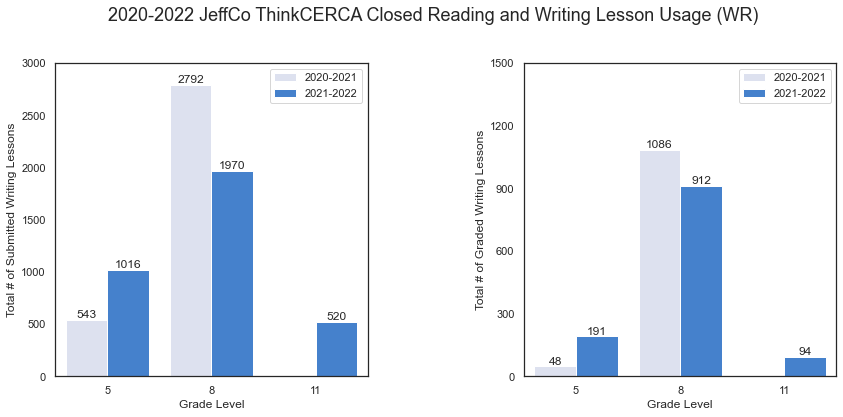

In [499]:
## plot
sns.set_theme(style="white", palette="deep",rc={"figure.figsize": (14,6)})

fig, axes = plt.subplots(1,2,sharey=False, sharex=True)
fig.subplots_adjust(wspace=0.5, top=0.85)
fig.suptitle('2020-2022 JeffCo ThinkCERCA Closed Reading and Writing Lesson Usage (WR)', fontsize=18)

for n, metric in enumerate(metrics_usg):
    sns.barplot(ax=axes[n],
                y=metric,
                x='enrolled_grade_2', 
                hue='school_year', 
                data=grouped_sbmt_grd[grouped_sbmt_grd['SUBJECT']=='WR'],
                palette=colors_usg)
    axes[n].set_xlabel('Grade Level')
    axes[n].tick_params(labelbottom=True, labelleft=True)
    axes[n].bar_label(axes[n].containers[0])
    axes[n].bar_label(axes[n].containers[1])
    axes[n].legend(loc='upper right')


axes[0].set_ylim(0,3000)
axes[0].set_yticks(range(0,3001,500))
axes[0].set_ylabel('Total # of Submitted Writing Lessons')

axes[1].set_ylim(0,1500)
axes[1].set_yticks(range(0,1501,300))
axes[1].set_ylabel('Total # of Graded Writing Lessons')

plt.savefig('/Users/spencersu/Desktop/JCPS external data mapping/2020-22 JeffCo Writing Lesson Usage (WR).png')

plt.show()

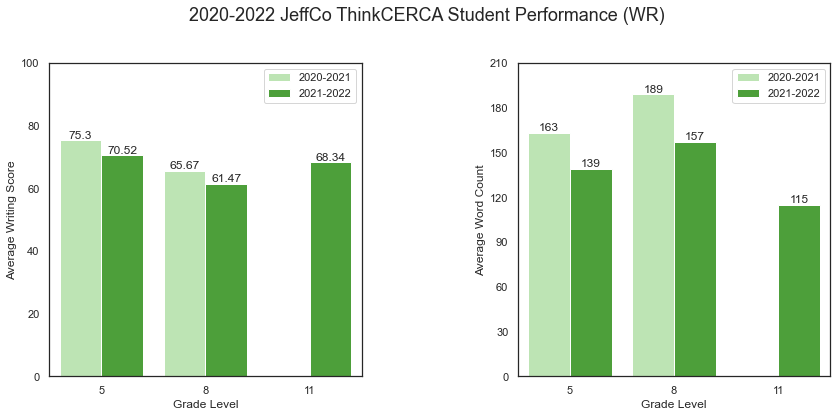

In [500]:
## plot
sns.set_theme(style="white", palette="deep",rc={"figure.figsize": (14,6)})

fig, axes = plt.subplots(1,2,sharey=False, sharex=True)
fig.subplots_adjust(wspace=0.5, top=0.85)
fig.suptitle('2020-2022 JeffCo ThinkCERCA Student Performance (WR)', fontsize=18)

for n, metric in enumerate(metrics_pfm):
    sns.barplot(ax=axes[n],
                y=metric,
                x='enrolled_grade_2', 
                hue='school_year', 
                data=grouped_avg_ws_wc[grouped_avg_ws_wc['SUBJECT']=='WR'],
                palette=colors_pfm)
    axes[n].set_xlabel('Grade Level')
    axes[n].tick_params(labelbottom=True, labelleft=True)
    axes[n].bar_label(axes[n].containers[0])
    axes[n].bar_label(axes[n].containers[1])
    axes[n].legend(loc='upper right')


axes[0].set_ylim(0,100)
axes[0].set_yticks(range(0,101,20))
axes[0].set_ylabel('Average Writing Score')

axes[1].set_ylim(0,200)
axes[1].set_yticks(range(0,211,30))
axes[1].set_ylabel('Average Word Count')

plt.savefig('/Users/spencersu/Desktop/JCPS external data mapping/2020-22 JeffCo Student Performance (WR).png')

plt.show()

In [244]:
## prepare data for proficiency level distribution by grade level graph
plt_n = ex_merged.groupby(['school_year','SUBJECT','enrolled_grade_2'])['NOVICE'].mean().reset_index()
plt_a = ex_merged.groupby(['school_year','SUBJECT','enrolled_grade_2'])['APPRENTICE'].mean().reset_index()
plt_p = ex_merged.groupby(['school_year','SUBJECT','enrolled_grade_2'])['PROFICIENT'].mean().reset_index()
plt_d = ex_merged.groupby(['school_year','SUBJECT','enrolled_grade_2'])['DISTINGUISHED'].mean().reset_index()

dfs2 = [plt_n, plt_a, plt_p, plt_d]
profct = reduce(lambda left,right: pd.merge(left,right,
                                            on=['school_year','SUBJECT','enrolled_grade_2'],
                                            how='outer'), dfs2)
profct['sum'] = profct['NOVICE'] + profct['APPRENTICE'] + profct['PROFICIENT'] + profct['DISTINGUISHED']

# profct_merged = pd.merge(empty_df, profct, on=['school_year','SUBJECT','enrolled_grade_2'], how='left')

profct_wr_20_21 = profct[(profct['SUBJECT']=='WR') & (profct['school_year']=='2020-2021')]
profct_wr_21_22 = profct[(profct['SUBJECT']=='WR') & (profct['school_year']=='2021-2022')]

profct_rd_20_21 = profct[(profct['SUBJECT']=='RD') & (profct['school_year']=='2020-2021')]
profct_rd_21_22 = profct[(profct['SUBJECT']=='RD') & (profct['school_year']=='2021-2022')]

## The four proficiency level approximately sum up to 100%

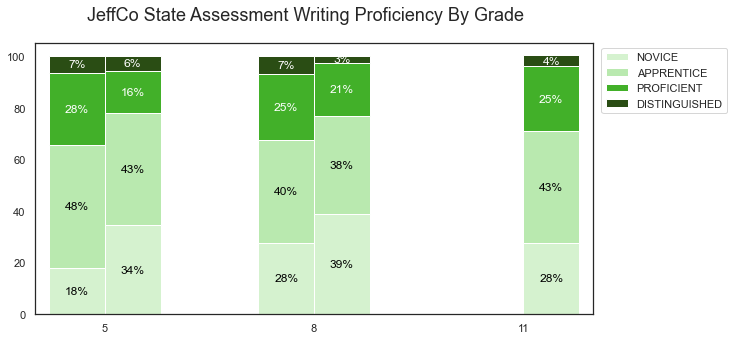

In [509]:
## plot 

sns.set_theme(style="white", palette="deep",rc={"figure.figsize": (10,5)})

fig, axes = plt.subplots(1,1)
fig.suptitle('JeffCo State Assessment Writing Proficiency By Grade', fontsize=18)
width = 0.8

ax1 = plt.bar(profct_wr_20_21['enrolled_grade_2']- width/2, profct_wr_20_21['NOVICE'], width, label='NOVICE', color='#D5F2CF')
ax2 = plt.bar(profct_wr_21_22['enrolled_grade_2']+ width/2, profct_wr_21_22['NOVICE'], width, label='NOVICE', color='#D5F2CF')

ax3 = plt.bar(profct_wr_20_21['enrolled_grade_2']- width/2, profct_wr_20_21['APPRENTICE'], width, 
       bottom=np.nan_to_num(profct_wr_20_21['NOVICE']),
       label='APPRENTICE', color='#B9E9AF')
ax4 = plt.bar(profct_wr_21_22['enrolled_grade_2']+ width/2, profct_wr_21_22['APPRENTICE'], width, 
       bottom=np.nan_to_num(profct_wr_21_22['NOVICE']),
       label='APPRENTICE', color='#B9E9AF')

ax5 = plt.bar(profct_wr_20_21['enrolled_grade_2']- width/2, profct_wr_20_21['PROFICIENT'], width, 
       bottom=np.nan_to_num(profct_wr_20_21['NOVICE'])+np.nan_to_num(profct_wr_20_21['APPRENTICE']),
       label='PROFICIENT', color='#42b029')
ax6 = plt.bar(profct_wr_21_22['enrolled_grade_2']+ width/2, profct_wr_21_22['PROFICIENT'], width, 
       bottom=np.nan_to_num(profct_wr_21_22['NOVICE'])+np.nan_to_num(profct_wr_21_22['APPRENTICE']),
       label='PROFICIENT', color='#42b029')

ax7 = plt.bar(profct_wr_20_21['enrolled_grade_2']- width/2, profct_wr_20_21['DISTINGUISHED'], width, 
       bottom=np.nan_to_num(profct_wr_20_21['NOVICE'])+np.nan_to_num(profct_wr_20_21['APPRENTICE'])+np.nan_to_num(profct_wr_20_21['PROFICIENT']),
       label='DISTINGUISHED', color='#2A4D14')
ax8 = plt.bar(profct_wr_21_22['enrolled_grade_2']+ width/2, profct_wr_21_22['DISTINGUISHED'], width, 
       bottom=np.nan_to_num(profct_wr_21_22['NOVICE'])+np.nan_to_num(profct_wr_21_22['APPRENTICE'])+np.nan_to_num(profct_wr_21_22['PROFICIENT']),
       label='DISTINGUISHED', color='#2A4D14')

for n in range(0,4):
    axes.bar_label(axes.containers[n],color='black',label_type='center',fmt='%.0f%%')
for n in range(4,8):
    axes.bar_label(axes.containers[n],color='white',label_type='center',fmt='%.0f%%')
plt.xlim(4,12)
plt.xticks(range(5,13,3))
plt.legend(ax1[:1]+ax3[:1]+ax5[:1]+ax7[:1], levels, loc='upper right',bbox_to_anchor=(1.25, 1.0))

plt.savefig('/Users/spencersu/Desktop/JCPS external data mapping/2020-22 Writing Proficiency By Grade.png',
            bbox_inches='tight')

plt.show()

### RD

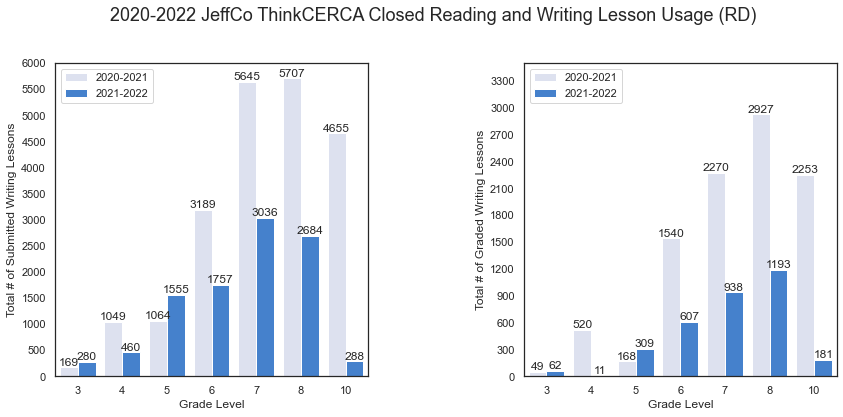

In [501]:
## plot
sns.set_theme(style="white", palette="deep",rc={"figure.figsize": (14,6)})

fig, axes = plt.subplots(1,2,sharey=False, sharex=True)
fig.subplots_adjust(wspace=0.5, top=0.85)
fig.suptitle('2020-2022 JeffCo ThinkCERCA Closed Reading and Writing Lesson Usage (RD)', fontsize=18)

for n, metric in enumerate(metrics_usg):
    sns.barplot(ax=axes[n],
                y=metric,
                x='enrolled_grade_2', 
                hue='school_year', 
                data=grouped_sbmt_grd[grouped_sbmt_grd['SUBJECT']=='RD'],
                palette=colors_usg)
    axes[n].set_xlabel('Grade Level')
    axes[n].tick_params(labelbottom=True, labelleft=True)
    axes[n].bar_label(axes[n].containers[0])
    axes[n].bar_label(axes[n].containers[1])
    axes[n].legend(loc='upper left')


axes[0].set_ylim(0,6000)
axes[0].set_yticks(range(0,6001,500))
axes[0].set_ylabel('Total # of Submitted Writing Lessons')

axes[1].set_ylim(0,3500)
axes[1].set_yticks(range(0,3501,300))
axes[1].set_ylabel('Total # of Graded Writing Lessons')

plt.savefig('/Users/spencersu/Desktop/JCPS external data mapping/2020-22 JeffCo Writing Lesson Usage (RD).png',
            bbox_inches='tight')

plt.show()

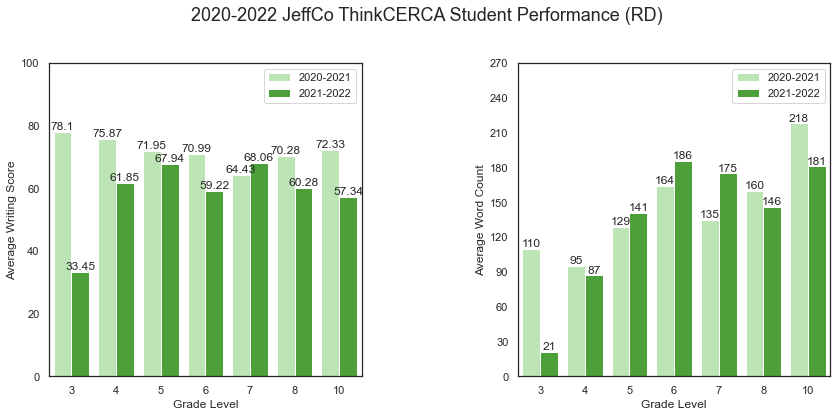

In [502]:
## plot
sns.set_theme(style="white", palette="deep",rc={"figure.figsize": (14,6)})

fig, axes = plt.subplots(1,2,sharey=False, sharex=True)
fig.subplots_adjust(wspace=0.5, top=0.85)
fig.suptitle('2020-2022 JeffCo ThinkCERCA Student Performance (RD)', fontsize=18)

for n, metric in enumerate(metrics_pfm):
    sns.barplot(ax=axes[n],
                y=metric,
                x='enrolled_grade_2', 
                hue='school_year', 
                data=grouped_avg_ws_wc[grouped_avg_ws_wc['SUBJECT']=='RD'],
                palette=colors_pfm)
    axes[n].set_xlabel('Grade Level')
    axes[n].tick_params(labelbottom=True, labelleft=True)
    axes[n].bar_label(axes[n].containers[0])
    axes[n].bar_label(axes[n].containers[1])
    axes[n].legend(loc='upper right')


axes[0].set_ylim(0,100)
axes[0].set_yticks(range(0,101,20))
axes[0].set_ylabel('Average Writing Score')

axes[1].set_ylim(0,270)
axes[1].set_yticks(range(0,271,30))
axes[1].set_ylabel('Average Word Count')

plt.savefig('/Users/spencersu/Desktop/JCPS external data mapping/2020-22 JeffCo Student Performance (RD).png',
            bbox_inches='tight')

plt.show()

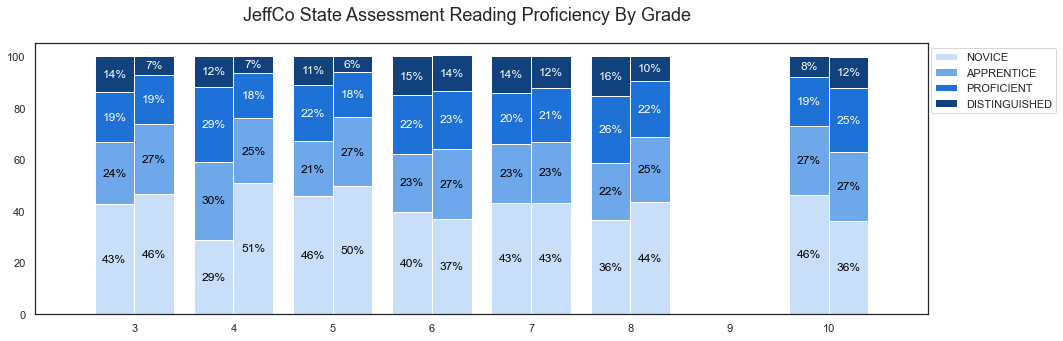

In [559]:
## plot 

sns.set_theme(style="white", palette="deep",rc={"figure.figsize": (16,5)})

fig, axes = plt.subplots(1,1)
fig.suptitle('JeffCo State Assessment Reading Proficiency By Grade', fontsize=18)
width = 0.4

ax1 = plt.bar(profct_rd_20_21['enrolled_grade_2']- width/2, profct_rd_20_21['NOVICE'], width, label='NOVICE', color='#c9def8')
ax2 = plt.bar(profct_rd_21_22['enrolled_grade_2']+ width/2, profct_rd_21_22['NOVICE'], width, label='NOVICE', color='#c9def8')

ax3 = plt.bar(profct_rd_20_21['enrolled_grade_2']- width/2, profct_rd_20_21['APPRENTICE'], width, 
       bottom=np.nan_to_num(profct_rd_20_21['NOVICE']),
       label='APPRENTICE', color='#6fa7eb')
ax4 = plt.bar(profct_rd_21_22['enrolled_grade_2']+ width/2, profct_rd_21_22['APPRENTICE'], width, 
       bottom=np.nan_to_num(profct_rd_21_22['NOVICE']),
       label='APPRENTICE', color='#6fa7eb')

ax5 = plt.bar(profct_rd_20_21['enrolled_grade_2']- width/2, profct_rd_20_21['PROFICIENT'], width, 
       bottom=np.nan_to_num(profct_rd_20_21['NOVICE'])+np.nan_to_num(profct_rd_20_21['APPRENTICE']),
       label='PROFICIENT', color='#1d71d7')
ax6 = plt.bar(profct_rd_21_22['enrolled_grade_2']+ width/2, profct_rd_21_22['PROFICIENT'], width, 
       bottom=np.nan_to_num(profct_rd_21_22['NOVICE'])+np.nan_to_num(profct_rd_21_22['APPRENTICE']),
       label='PROFICIENT', color='#1d71d7')

ax7 = plt.bar(profct_rd_20_21['enrolled_grade_2']- width/2, profct_rd_20_21['DISTINGUISHED'], width, 
       bottom=np.nan_to_num(profct_rd_20_21['NOVICE'])+np.nan_to_num(profct_rd_20_21['APPRENTICE'])+np.nan_to_num(profct_rd_20_21['PROFICIENT']),
       label='DISTINGUISHED', color='#11427e')
ax8 = plt.bar(profct_rd_21_22['enrolled_grade_2']+ width/2, profct_rd_21_22['DISTINGUISHED'], width, 
       bottom=np.nan_to_num(profct_rd_21_22['NOVICE'])+np.nan_to_num(profct_rd_21_22['APPRENTICE'])+np.nan_to_num(profct_rd_21_22['PROFICIENT']),
       label='DISTINGUISHED', color='#11427e')

for n in range(0,4):
    axes.bar_label(axes.containers[n],color='black',label_type='center',fmt='%.0f%%')
for n in range(4,8):
    axes.bar_label(axes.containers[n],color='white',label_type='center',fmt='%.0f%%')
plt.xlim(2,11)
plt.xticks(range(3,11))
plt.legend(ax1[:1]+ax3[:1]+ax5[:1]+ax7[:1], levels, loc='upper right',bbox_to_anchor=(1.15, 1.0))

plt.savefig('/Users/spencersu/Desktop/JCPS external data mapping/2020-22 Reading Proficiency By Grade.png',
            bbox_inches='tight')

plt.show()

In [28]:
# for level in levels:
#     for year in years:
#         sns.displot(ex_merged[ex_merged['school_year']==year][level],kde=True)
#         plt.show() 

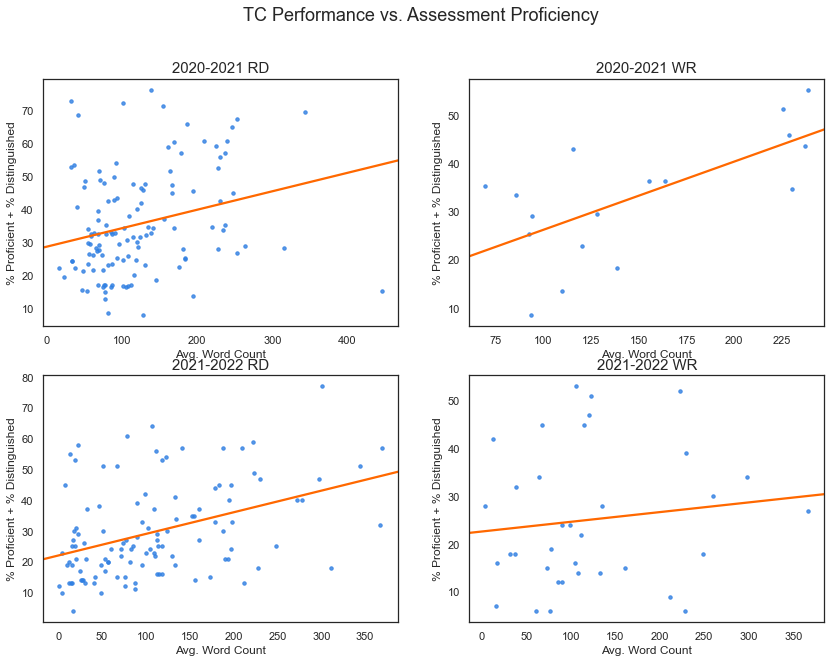

In [29]:
fig, axes = plt.subplots(2,2,figsize=(14, 10))
fig.suptitle('TC Performance vs. Assessment Proficiency', fontsize=18)

sns.set_style(style='white')

for n1, year in enumerate(years):
    for n2, subject in enumerate(subjects):
        sns.regplot(ax=axes[n1,n2],
                    x=ex_merged[(ex_merged['school_year']==year) & (ex_merged['SUBJECT']==subject)]['avg_wc'],
                    y=ex_merged[(ex_merged['school_year']==year) 
                                & (ex_merged['SUBJECT']==subject)]['PROFICIENT'] + 
                      ex_merged[(ex_merged['school_year']==year) 
                                & (ex_merged['SUBJECT']==subject)]['DISTINGUISHED'], 
                    scatter_kws={"color": "#2f7fe2",'s':12}, 
                    truncate = False, x_jitter=.3, marker='o', line_kws={"color": "#ff6800"}, ci=None)
        axes[n1,n2].set_xlabel('Avg. Word Count')
        axes[n1,n2].set_ylabel('% Proficient + % Distinguished')
        axes[n1,n2].set_title(str(year) + ' ' + str(subject), fontsize=15)
#     plt.savefig(os.path.join(path,'Usage vs. Word Count (Order ' + str(n) +').png'))
plt.show()

In [650]:
## I tried to use the number of assignments on student level but it does not make sense 
## because per student data is very small
## also the proficiency level is on the grade level 

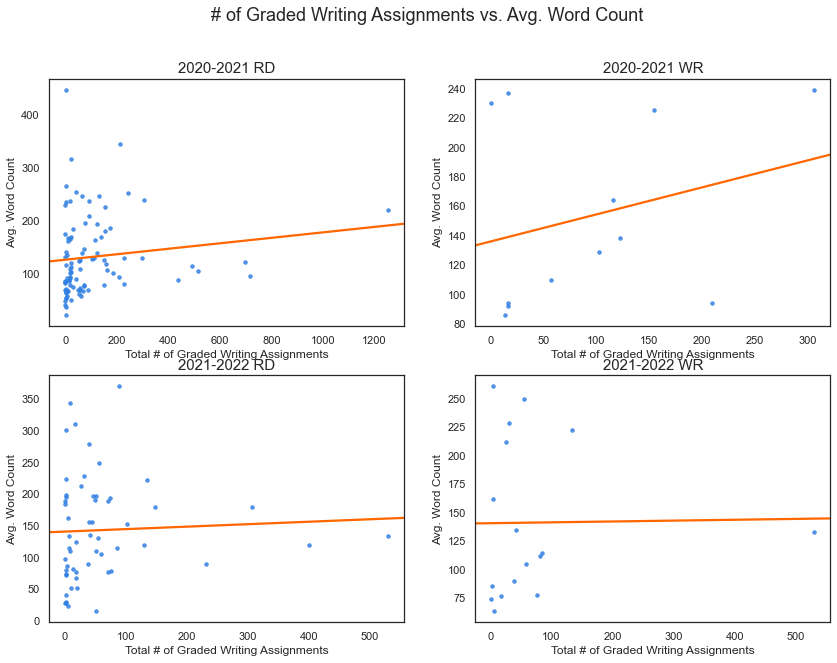

In [565]:
fig, axes = plt.subplots(2,2,figsize=(14, 10))
fig.suptitle('# of Graded Writing Assignments vs. Avg. Word Count', fontsize=18)

sns.set_style(style='white')

for n1, year in enumerate(years):
    for n2, subject in enumerate(subjects):
        sns.regplot(ax=axes[n1,n2],
                    x=ex_merged[(ex_merged['school_year']==year) 
                                & (ex_merged['SUBJECT']==subject)]['tot_num_asmt_grd'],
                    y=ex_merged[(ex_merged['school_year']==year) & (ex_merged['SUBJECT']==subject)]['avg_wc'], 
                    scatter_kws={"color": "#2f7fe2",'s':12}, 
                    truncate = False, x_jitter=.3, marker='o', line_kws={"color": "#ff6800"}, ci=None)
        axes[n1,n2].set_xlabel('Total # of Graded Writing Assignments')
        axes[n1,n2].set_ylabel('Avg. Word Count')
        axes[n1,n2].set_title(str(year) + ' ' + str(subject), fontsize=15)
#     plt.savefig(os.path.join(path,'Usage vs. Word Count (Order ' + str(n) +').png'))
plt.show()

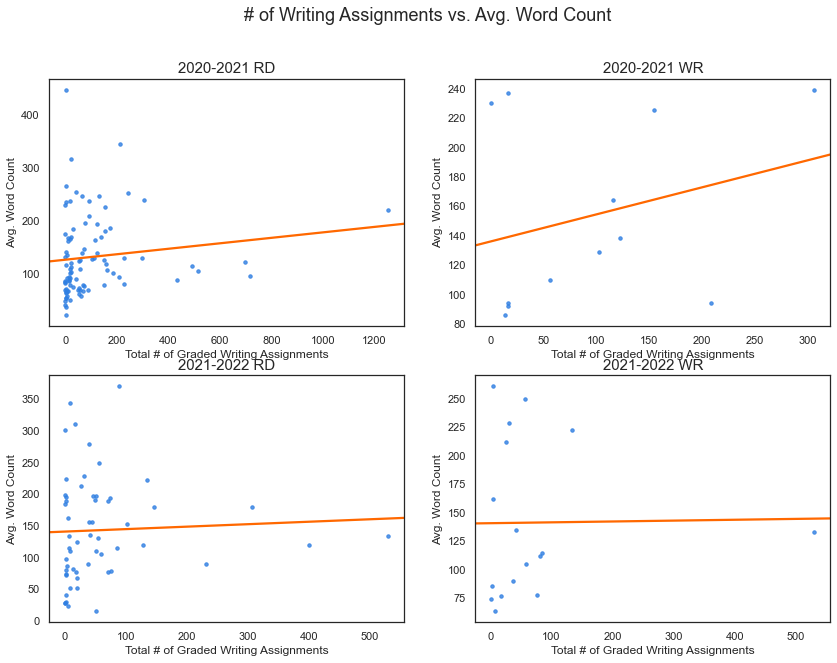

In [315]:
fig, axes = plt.subplots(2,2,figsize=(14, 10))
fig.suptitle('# of Writing Assignments vs. Avg. Word Count', fontsize=18)

sns.set_style(style='white')

for n1, year in enumerate(years):
    for n2, subject in enumerate(subjects):
        sns.regplot(ax=axes[n1,n2],
                    x=ex_merged[(ex_merged['school_year']==year) 
                                & (ex_merged['SUBJECT']==subject)]['tot_num_asmt_grd'],
                    y=ex_merged[(ex_merged['school_year']==year) & (ex_merged['SUBJECT']==subject)]['avg_wc'], 
                    scatter_kws={"color": "#2f7fe2",'s':12}, 
                    truncate = False, x_jitter=.3, marker='o', line_kws={"color": "#ff6800"}, ci=None)
        axes[n1,n2].set_xlabel('Total # of Graded Writing Assignments')
        axes[n1,n2].set_ylabel('Avg. Word Count')
        axes[n1,n2].set_title(str(year) + ' ' + str(subject), fontsize=15)
#     plt.savefig(os.path.join(path,'Usage vs. Word Count (Order ' + str(n) +').png'))
plt.show()

## Correlational Analysis

In [31]:
## prepare dataset for correlational analysis
## subset: top ten users (schools) and bottom ten users
full_sch_list = ex_merged.groupby(['school_year',
                                   'school_name',
                                   'school_id'])['enrolled_grade_2'].count().reset_index()
full_sch_list = full_sch_list.iloc[:,0:3]


## --------------------------
## num of students submitting / submitted assignments (expanding from writing lesson to all lesson types)
num_sbmt_sch = intnl_sbmt_grd[(intnl_sbmt_grd['Student Assignment Status'].isin(['needs_grading',
                                                                                'graded',
                                                                                'scoreless']))]
#                               &(intnl_sbmt_grd['Lesson Type']=='Writing Lesson')]

num_sbmt_sch = num_sbmt_sch.groupby(['School Year',
                                     'School Id',
                                     'School Name'])['Student Assignment Id',
                                                     'Student Id [Sensitive]'].nunique().reset_index()

num_sbmt_sch = num_sbmt_sch.rename(columns = {'Student Id [Sensitive]':'tot_num_stu_sbmt',
                                              'Student Assignment Id':'tot_num_asmt_sbmt'})

## student level avg submitted assignments by enrolled grade and lesson type 
num_sbmt_sch['avg_asmt_sbmt'] = num_sbmt_sch['tot_num_asmt_sbmt'] / num_sbmt_sch['tot_num_stu_sbmt']

## only wr:
## num_sbmt_sch: 185 rows × 6 columns, this is on the school level instead of grade or student assignment level
## 113 schools

## all lesson types: 197 rows, 120 schools


## ---------------------------
## num of students getting graded / graded assignments
num_grd_sch = intnl_sbmt_grd[(intnl_sbmt_grd['Student Assignment Status'].isin(['graded',
                                                                                'scoreless']))] 
#                              & (intnl_sbmt_grd['Lesson Type']=='Writing Lesson')]

num_grd_sch = num_grd_sch.groupby(['School Year',
                                   'School Id',
                                   'School Name'])['Student Assignment Id',
                                                   'Student Id [Sensitive]'].nunique().reset_index()

num_grd_sch = num_grd_sch.rename(columns = {'Student Id [Sensitive]':'tot_num_stu_grd',
                                            'Student Assignment Id':'tot_num_asmt_grd'})

## student level avg submitted assignments by enrolled grade and lesson type 
num_grd_sch['avg_asmt_grd'] = num_grd_sch['tot_num_asmt_grd'] / num_grd_sch['tot_num_stu_grd']

## only wr: num_grd_sch: 135 rows × 6 columns
## 90 schools
## all lesson type: 164 rows, 103 schools

In [32]:
sch_usg = pd.merge(num_sbmt_sch, num_grd_sch, on=['School Year','School Id','School Name'], how='outer') #185 rows
sch_usg = pd.merge(full_sch_list, sch_usg, 
                   left_on=['school_year','school_name','school_id'], 
                   right_on=['School Year','School Name','School Id'],
                   how='left') #127 rows × 12 columns, 81 schools in total

In [33]:
## some grade levels might be lost after merging

## 2020-2021 top 10 schools with the highest number of writing lesson submission 
# print('2020-21 Top 10 schools w/ highest # of wr submission: \n',ex_merged[ex_merged['school_year'] =='2020-2021'].groupby(['school_id','school_name'])['tot_num_asmt_sbmt'].sum().reset_index().sort_values('tot_num_asmt_sbmt',ascending=False).head(10),'\n')

# ## 2020-2021 top 10 schools with the most number of graded writing lesson 
# print('2020-21 Top 10 schools w/ highest # of graded wr: \n',ex_merged[ex_merged['school_year'] =='2020-2021'].groupby(['school_id','school_name'])['tot_num_asmt_grd'].sum().reset_index().sort_values('tot_num_asmt_grd',ascending=False).head(10),'\n')

In [34]:
## 2020-2021 top 10 schools with the highest number of writing lesson submission 
print('2020-21 Top 10 schools w/ highest # of submission: \n',
      sch_usg[['school_id',
               'school_name',
               'tot_num_asmt_sbmt']][sch_usg['school_year'] =='2020-2021'].sort_values('tot_num_asmt_sbmt',ascending=False).head(20),'\n')

## 2020-2021 top 10 schools with the highest average number of writing lesson submission 
print('2020-21 Top 10 schools w/ highest avg # of submission: \n', 
      sch_usg[['school_id',
               'school_name',
               'avg_asmt_sbmt']][sch_usg['school_year'] =='2020-2021'].sort_values('avg_asmt_sbmt',ascending=False).head(10),'\n')

## 2020-2021 top 10 schools with the most number of graded writing lesson 
print('2020-21 Top 10 schools w/ highest # of graded wr: \n',
      sch_usg[['school_id',
               'school_name',
               'tot_num_asmt_grd']][sch_usg['school_year'] =='2020-2021'].sort_values('tot_num_asmt_grd',ascending=False).head(10),'\n')

## 2020-2021 top 10 schools with the highest average number of graded writing lesson 
print('2020-21 Top 10 schools w/ highest avg # of graded wr: \n', 
      sch_usg[['school_id',
               'school_name',
               'avg_asmt_grd']][sch_usg['school_year'] =='2020-2021'].sort_values('avg_asmt_grd',ascending=False).head(10))

2020-21 Top 10 schools w/ highest # of submission: 
     school_id                          school_name  tot_num_asmt_sbmt
6      165881              Butler Traditional High               5329
48      96738              Thomas Jefferson Middle               4872
14      96767                         Eastern High               2745
38     165879                       Newburg Middle               2706
47      96778                       Stuart Academy               2699
12      96766                        Crosby Middle               2385
28     165851                      Kammerer Middle               1984
24      96862                        Iroquois High               1946
36      96806                       Meyzeek Middle               1827
34      96752               Marion C. Moore School               1766
45     165863                        Southern High               1555
20     165842  Frederick Law Olmsted Academy South               1519
1       96817            Barret Tradi

In [35]:
## 2021-2022 top 10 schools with the highest number of writing lesson submission 
print('2021-2022 Top 10 schools w/ highest # of submission: \n',
      sch_usg[['school_id',
               'school_name',
               'tot_num_asmt_sbmt']][sch_usg['school_year'] =='2021-2022'].sort_values('tot_num_asmt_sbmt',ascending=False).head(20),'\n')

## 2021-2022 top 10 schools with the highest average number of writing lesson submission 
print('2021-2022 Top 10 schools w/ highest avg # of submission: \n', 
      sch_usg[['school_id',
               'school_name',
               'avg_asmt_sbmt']][sch_usg['school_year'] =='2021-2022'].sort_values('avg_asmt_sbmt',ascending=False).head(10),'\n')

## 2021-2022 top 10 schools with the most number of graded writing lesson 
print('2021-2022 Top 10 schools w/ highest # of graded wr: \n',
      sch_usg[['school_id',
               'school_name',
               'tot_num_asmt_grd']][sch_usg['school_year'] =='2021-2022'].sort_values('tot_num_asmt_grd',ascending=False).head(10),'\n')

## 2021-2022 top 10 schools with the highest average number of graded writing lesson 
print('2021-2022 Top 10 schools w/ highest avg # of graded wr: \n', 
      sch_usg[['school_id',
               'school_name',
               'avg_asmt_grd']][sch_usg['school_year'] =='2021-2022'].sort_values('avg_asmt_grd',ascending=False).head(10))

2021-2022 Top 10 schools w/ highest # of submission: 
      school_id                          school_name  tot_num_asmt_sbmt
117      96738              Thomas Jefferson Middle               4247
102     165879                       Newburg Middle               2525
115      96778                       Stuart Academy               2392
72       96766                        Crosby Middle               1913
81      165842  Frederick Law Olmsted Academy South               1391
122      96873                         Western High               1304
71      165865                        Conway Middle               1166
87       96862                        Iroquois High               1074
116     165846                The Academy @ Shawnee               1070
94       96755                        Knight Middle               1021
124     165785                  Wheatley Elementary                996
85       96814                      Highland Middle                915
66      165881        

In [36]:
lst_top10_sbmt_20_21 = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][sch_usg['school_year'] =='2020-2021'].sort_values('tot_num_asmt_sbmt',ascending=False).head(10)
lst_top10_sbmt_20_21 = lst_top10_sbmt_20_21['school_id'].values.tolist()
lst_btm10_sbmt_20_21 = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][sch_usg['school_year'] =='2020-2021'].sort_values('tot_num_asmt_sbmt',ascending=False).tail(10)
lst_btm10_sbmt_20_21 = lst_btm10_sbmt_20_21['school_id'].values.tolist()

df_top10_sbmt_20_21 = ex_merged[(ex_merged['school_id'].isin(lst_top10_sbmt_20_21)) 
                                & (ex_merged['school_year']=='2020-2021')] #30 rows
df_btm10_sbmt_20_21 = ex_merged[ex_merged['school_id'].isin(lst_btm10_sbmt_20_21)
                                & (ex_merged['school_year']=='2020-2021')] #19 rows

# print(df_top10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['NOVICE'].mean())
# print(df_btm10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['NOVICE'].mean())

# print(df_top10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['APPRENTICE'].mean())
# print(df_btm10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['APPRENTICE'].mean())

print(df_top10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['PROFICIENT'].mean())
print(df_btm10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['PROFICIENT'].mean())

## the number of students in these schools might be very different, might not be a good idea to compare

SUBJECT  GRADE
RD       6        22.466667
         7        18.571429
         8        24.171429
         10       17.675000
WR       8        22.820000
Name: PROFICIENT, dtype: float64
SUBJECT  GRADE
RD       3        14.800000
         4        25.287500
         5        22.833333
         7        24.100000
WR       5        39.700000
Name: PROFICIENT, dtype: float64


In [37]:
lst_top10_sbmt_21_22 = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][sch_usg['school_year'] =='2021-2022'].sort_values('tot_num_asmt_sbmt',ascending=False).head(10)
lst_top10_sbmt_21_22 = lst_top10_sbmt_21_22['school_id'].values.tolist()
lst_btm10_sbmt_21_22 = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][sch_usg['school_year'] =='2021-2022'].sort_values('tot_num_asmt_sbmt',ascending=False).tail(10)
lst_btm10_sbmt_21_22 = lst_btm10_sbmt_21_22['school_id'].values.tolist()

df_top10_sbmt_21_22 = ex_merged[(ex_merged['school_id'].isin(lst_top10_sbmt_21_22)) 
                                & (ex_merged['school_year']=='2021-2022')] #30 rows
df_btm10_sbmt_21_22 = ex_merged[ex_merged['school_id'].isin(lst_btm10_sbmt_21_22)
                                & (ex_merged['school_year']=='2021-2022')] #19 rows

# print(df_top10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['NOVICE'].mean())
# print(df_btm10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['NOVICE'].mean())

# print(df_top10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['APPRENTICE'].mean())
# print(df_btm10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['APPRENTICE'].mean())

# print(df_top10_sbmt_21_22.groupby(['SUBJECT','GRADE'])['PROFICIENT'].mean())
# print(df_btm10_sbmt_21_22.groupby(['SUBJECT','GRADE'])['PROFICIENT'].mean())

print(df_top10_sbmt_21_22.groupby(['SUBJECT','GRADE'])['DISTINGUISHED'].mean())
print(df_btm10_sbmt_21_22.groupby(['SUBJECT','GRADE'])['DISTINGUISHED'].mean())

SUBJECT  GRADE
RD       6        8.400000
         7        7.250000
         8        6.571429
         10       4.333333
SS       8        5.714286
         11       3.500000
WR       8        1.600000
         11       2.000000
Name: DISTINGUISHED, dtype: float64
SUBJECT  GRADE
RD       3        11.000000
         4         3.000000
         5        10.750000
         7        11.000000
         10        8.000000
SS       5        11.000000
         11        5.000000
WR       5         8.333333
         11        3.500000
Name: DISTINGUISHED, dtype: float64


In [38]:
lst_top20_sbmt_20_21 = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][sch_usg['school_year'] =='2020-2021'].sort_values('tot_num_asmt_sbmt',ascending=False).head(20)
lst_top20_sbmt_20_21 = lst_top20_sbmt_20_21['school_id'].values.tolist()
lst_btm20_sbmt_20_21 = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][sch_usg['school_year'] =='2020-2021'].sort_values('tot_num_asmt_sbmt',ascending=False).tail(20)
lst_btm20_sbmt_20_21 = lst_btm20_sbmt_20_21['school_id'].values.tolist()

df_top20_sbmt_20_21 = ex_merged[(ex_merged['school_id'].isin(lst_top20_sbmt_20_21)) 
                                & (ex_merged['school_year']=='2020-2021')] #30 rows
df_btm20_sbmt_20_21 = ex_merged[ex_merged['school_id'].isin(lst_btm20_sbmt_20_21)
                                & (ex_merged['school_year']=='2020-2021')] #19 rows

# print(df_top10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['NOVICE'].mean())
# print(df_btm10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['NOVICE'].mean())

# print(df_top10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['APPRENTICE'].mean())
# print(df_btm10_sbmt_20_21.groupby(['SUBJECT','GRADE'])['APPRENTICE'].mean())

# print(df_top20_sbmt_20_21.groupby(['SUBJECT','GRADE'])['PROFICIENT'].mean())
# print(df_btm20_sbmt_20_21.groupby(['SUBJECT','GRADE'])['PROFICIENT'].mean())

print(df_top20_sbmt_20_21.groupby(['SUBJECT','GRADE'])['DISTINGUISHED'].mean())
print(df_btm20_sbmt_20_21.groupby(['SUBJECT','GRADE'])['DISTINGUISHED'].mean())

SUBJECT  GRADE
RD       6        15.125000
         7        11.828571
         8        15.271429
         10        7.057143
WR       8         6.233333
Name: DISTINGUISHED, dtype: float64
SUBJECT  GRADE
RD       3        12.250000
         4        10.266667
         5         9.930000
         7        14.100000
         10        7.733333
WR       5         7.400000
Name: DISTINGUISHED, dtype: float64


In [39]:
lst_top20_sbmt_21_22 = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][sch_usg['school_year'] =='2021-2022'].sort_values('tot_num_asmt_sbmt',ascending=False).head(20)
lst_top20_sbmt_21_22 = lst_top20_sbmt_21_22['school_id'].values.tolist()
lst_btm20_sbmt_21_22 = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][sch_usg['school_year'] =='2021-2022'].sort_values('tot_num_asmt_sbmt',ascending=False).tail(20)
lst_btm20_sbmt_21_22 = lst_btm20_sbmt_21_22['school_id'].values.tolist()

df_top20_sbmt_21_22 = ex_merged[(ex_merged['school_id'].isin(lst_top20_sbmt_21_22)) 
                                & (ex_merged['school_year']=='2021-2022')] #30 rows
df_btm20_sbmt_21_22 = ex_merged[ex_merged['school_id'].isin(lst_btm20_sbmt_21_22)
                                & (ex_merged['school_year']=='2021-2022')] #19 rows

# print(df_top20_sbmt_20_21.groupby(['SUBJECT','GRADE'])['NOVICE'].mean())
# print(df_btm20_sbmt_20_21.groupby(['SUBJECT','GRADE'])['NOVICE'].mean())

# print(df_top20_sbmt_20_21.groupby(['SUBJECT','GRADE'])['APPRENTICE'].mean())
# print(df_btm20_sbmt_20_21.groupby(['SUBJECT','GRADE'])['APPRENTICE'].mean())

print(df_top20_sbmt_21_22.groupby(['SUBJECT','GRADE'])['PROFICIENT'].mean())
print(df_btm20_sbmt_21_22.groupby(['SUBJECT','GRADE'])['PROFICIENT'].mean())

# print(df_top20_sbmt_21_22.groupby(['SUBJECT','GRADE'])['DISTINGUISHED'].mean())
# print(df_btm20_sbmt_21_22.groupby(['SUBJECT','GRADE'])['DISTINGUISHED'].mean())

SUBJECT  GRADE
RD       3        18.000000
         4         7.000000
         5        10.000000
         6        20.454545
         7        18.857143
         8        19.090909
         10       17.500000
SS       5         5.000000
         8        15.636364
         11       15.250000
WR       5         7.000000
         8        17.333333
         11       22.666667
Name: PROFICIENT, dtype: float64
SUBJECT  GRADE
RD       3        22.500000
         4        22.800000
         5        23.000000
         6        35.000000
         7        26.500000
         10       29.000000
SS       5        22.111111
         11       26.333333
WR       5        22.428571
         11       28.666667
Name: PROFICIENT, dtype: float64


In [40]:
np.corrcoef(df_top10_sbmt_20_21['tot_num_asmt_sbmt'],df_top10_sbmt_20_21['DISTINGUISHED'])
# df_btm20_sbmt_21_22
# np.corrcoef(ex_merged['avg_mc'],ex_merged['tot_num_asmt_grd'])

array([[ 1.        , -0.41738967],
       [-0.41738967,  1.        ]])

In [41]:
print(df_top20_sbmt_20_21['tot_num_asmt_sbmt'].corr(df_top20_sbmt_20_21['PROFICIENT'], method='spearman'))
print(df_top20_sbmt_20_21['tot_num_asmt_sbmt'].corr(df_top20_sbmt_20_21['PROFICIENT'], method='kendall'))

-0.3398629130626577
-0.25008163265523686


In [42]:
print(ex_merged['tot_num_asmt_sbmt'].corr(ex_merged['avg_wc'], method='spearman'))
print(ex_merged['tot_num_asmt_sbmt'].corr(ex_merged['avg_wc'], method='kendall'))

0.3933791311606298
0.27158474044769865


In [43]:
# years = ['2020-2021','2021-2022']
# subjects = ['RD','WR']

dict = {}

for year in years:
    for subject in subjects:
        df = ex_merged[(ex_merged['SUBJECT']==subject) & (ex_merged['school_year']==year)]  
        dict[f"df_{year}_{subject}"] =df

rd_20_21 = dict['df_2020-2021_RD']
rd_21_22 = dict['df_2021-2022_RD']
wr_20_21 = dict['df_2020-2021_WR']
wr_21_22 = dict['df_2021-2022_WR']

In [44]:
print(wr_21_22['tot_num_asmt_sbmt'].corr(wr_21_22['PROFICIENT'], method='spearman'))
print(wr_21_22['tot_num_asmt_sbmt'].corr(wr_21_22['PROFICIENT'], method='kendall'))
print(wr_21_22['tot_num_asmt_sbmt'].corr(wr_21_22['PROFICIENT'], method='pearson'))

0.18032383953056094
0.12904048281109579
-0.022738965015220738


In [45]:
print(wr_21_22['PROFICIENT'].corr(wr_21_22['avg_wc'], method='spearman'))
print(wr_21_22['PROFICIENT'].corr(wr_21_22['avg_wc'], method='kendall'))

0.28693747748360876
0.1943938178364092


In [46]:
def print_corr(df):
    print('tot_num_asmt_sbmt ~ PROFICIENT',
          df['tot_num_asmt_sbmt'].corr(df['PROFICIENT'], method='spearman'),
          '\n')
    print('tot_num_asmt_sbmt ~ DISTINGUISHED',
          df['tot_num_asmt_sbmt'].corr(df['DISTINGUISHED'], method='spearman'),
          '\n')
    print('tot_num_asmt_sbmt ~ NOVICE',
          df['tot_num_asmt_sbmt'].corr(df['NOVICE'], method='spearman'),
          '\n')
    print('tot_num_asmt_sbmt ~ APPRENTICE',
          df['tot_num_asmt_sbmt'].corr(df['APPRENTICE'], method='spearman'),
          '\n')
    print('avg_wc ~ PROFICIENT',
          df['avg_wc'].corr(df['PROFICIENT'], method='spearman'),
          '\n')
    print('avg_wc ~ DISTINGUISHED',
          df['avg_wc'].corr(df['DISTINGUISHED'], method='spearman'),
          '\n')
    print('avg_wc ~ NOVICE',
          df['avg_wc'].corr(df['NOVICE'], method='spearman'),
          '\n')
    print('avg_wc ~ APPRENTICE',
          df['avg_wc'].corr(df['APPRENTICE'], method='spearman'),
          '\n')
    print('tot_num_asmt_sbmt ~ avg_wc',
          df['avg_wc'].corr(df['tot_num_asmt_sbmt'], method='spearman'),
          '\n')

In [47]:
print_corr(rd_20_21)

tot_num_asmt_sbmt ~ PROFICIENT 0.012648075662486715 

tot_num_asmt_sbmt ~ DISTINGUISHED -0.02072376467474627 

tot_num_asmt_sbmt ~ NOVICE 0.0027456108052374088 

tot_num_asmt_sbmt ~ APPRENTICE -0.10313759467353792 

avg_wc ~ PROFICIENT 0.14997303996302438 

avg_wc ~ DISTINGUISHED 0.2776509559449652 

avg_wc ~ NOVICE -0.20598681365177482 

avg_wc ~ APPRENTICE -0.1791826179038346 

tot_num_asmt_sbmt ~ avg_wc 0.24640453620679081 



In [48]:
print_corr(rd_21_22)

tot_num_asmt_sbmt ~ PROFICIENT -0.059221855427996656 

tot_num_asmt_sbmt ~ DISTINGUISHED 0.06065173354380011 

tot_num_asmt_sbmt ~ NOVICE 0.06904291590441353 

tot_num_asmt_sbmt ~ APPRENTICE -0.08959386692787275 

avg_wc ~ PROFICIENT 0.3544184709550162 

avg_wc ~ DISTINGUISHED 0.4442316813230543 

avg_wc ~ NOVICE -0.39372868366782415 

avg_wc ~ APPRENTICE 0.07379930163238399 

tot_num_asmt_sbmt ~ avg_wc 0.435756104232292 



In [49]:
print_corr(ex_merged)

tot_num_asmt_sbmt ~ PROFICIENT 0.03320646658319736 

tot_num_asmt_sbmt ~ DISTINGUISHED 0.016298578239485047 

tot_num_asmt_sbmt ~ NOVICE -0.02393311236320868 

tot_num_asmt_sbmt ~ APPRENTICE -0.06985038496888518 

avg_wc ~ PROFICIENT 0.27203696022378754 

avg_wc ~ DISTINGUISHED 0.24812401077840612 

avg_wc ~ NOVICE -0.285049125903872 

avg_wc ~ APPRENTICE -0.004324991490562708 

tot_num_asmt_sbmt ~ avg_wc 0.3933791311606298 



In [50]:
print_corr(wr_20_21)

tot_num_asmt_sbmt ~ PROFICIENT -0.34947891302047995 

tot_num_asmt_sbmt ~ DISTINGUISHED -0.09570559351547257 

tot_num_asmt_sbmt ~ NOVICE 0.20478238061200058 

tot_num_asmt_sbmt ~ APPRENTICE -0.18382352941176472 

avg_wc ~ PROFICIENT 0.6499081540380856 

avg_wc ~ DISTINGUISHED 0.22699403590208236 

avg_wc ~ NOVICE -0.17167385201006033 

avg_wc ~ APPRENTICE -0.627450980392157 

tot_num_asmt_sbmt ~ avg_wc -0.04411764705882353 



In [51]:
print_corr(wr_21_22)

tot_num_asmt_sbmt ~ PROFICIENT 0.18032383953056094 

tot_num_asmt_sbmt ~ DISTINGUISHED -0.11825905037802371 

tot_num_asmt_sbmt ~ NOVICE -0.11765085290118725 

tot_num_asmt_sbmt ~ APPRENTICE 0.04087426323288368 

avg_wc ~ PROFICIENT 0.28693747748360876 

avg_wc ~ DISTINGUISHED -0.19959507570863647 

avg_wc ~ NOVICE -0.1776906108751032 

avg_wc ~ APPRENTICE -0.06257902931916356 

tot_num_asmt_sbmt ~ avg_wc 0.6380445503133843 



In [318]:
def print_corr_grd(df):
    print('tot_num_asmt_grd ~ PROFICIENT',
          df['tot_num_asmt_grd'].corr(df['PROFICIENT'], method='spearman'),
          '\n')
    print('tot_num_asmt_grd ~ DISTINGUISHED',
          df['tot_num_asmt_grd'].corr(df['DISTINGUISHED'], method='spearman'),
          '\n')
    print('tot_num_asmt_grd ~ NOVICE',
          df['tot_num_asmt_grd'].corr(df['NOVICE'], method='spearman'),
          '\n')
    print('tot_num_asmt_grd ~ APPRENTICE',
          df['tot_num_asmt_grd'].corr(df['APPRENTICE'], method='spearman'),
          '\n')
    print('tot_num_asmt_grd ~ avg_wc',
          df['avg_wc'].corr(df['tot_num_asmt_grd'], method='spearman'),
          '\n')

In [319]:
print_corr_grd(rd_20_21)

tot_num_asmt_grd ~ PROFICIENT -0.02475279333380575 

tot_num_asmt_grd ~ DISTINGUISHED 0.02571913207532648 

tot_num_asmt_grd ~ NOVICE -0.025864036649841146 

tot_num_asmt_grd ~ APPRENTICE -0.17389976295844176 

tot_num_asmt_grd ~ avg_wc 0.30871222241687096 



In [320]:
print_corr_grd(rd_21_22)

tot_num_asmt_grd ~ PROFICIENT -0.07662725279105793 

tot_num_asmt_grd ~ DISTINGUISHED 0.03139831500452255 

tot_num_asmt_grd ~ NOVICE 0.10199975466487947 

tot_num_asmt_grd ~ APPRENTICE -0.23828813917041375 

tot_num_asmt_grd ~ avg_wc 0.19979915442498686 



In [321]:
print_corr_grd(ex_merged)

tot_num_asmt_grd ~ PROFICIENT -0.007521882088326588 

tot_num_asmt_grd ~ DISTINGUISHED 0.040373519109553224 

tot_num_asmt_grd ~ NOVICE 0.007493342030057115 

tot_num_asmt_grd ~ APPRENTICE -0.16358856027837637 

tot_num_asmt_grd ~ avg_wc 0.24105479348828604 



In [322]:
print_corr_grd(wr_20_21)

tot_num_asmt_grd ~ PROFICIENT -0.0811298834082363 

tot_num_asmt_grd ~ DISTINGUISHED 0.059965565997392056 

tot_num_asmt_grd ~ NOVICE 0.47619714174399586 

tot_num_asmt_grd ~ APPRENTICE -0.8028368093325585 

tot_num_asmt_grd ~ avg_wc 0.2746546979295595 



In [323]:
print_corr_grd(wr_21_22)

tot_num_asmt_grd ~ PROFICIENT 0.36877863139415434 

tot_num_asmt_grd ~ DISTINGUISHED -0.04243151221964387 

tot_num_asmt_grd ~ NOVICE -0.19987741341171308 

tot_num_asmt_grd ~ APPRENTICE -0.2773008222371385 

tot_num_asmt_grd ~ avg_wc 0.20833333333333337 



In [332]:
ex_merged[~ex_merged['tot_num_asmt_sbmt'].isna()].groupby(['SUBJECT', 'School Year'])['school_name'].count()

SUBJECT  School Year
RD       2020-2021      125
         2021-2022      120
SS       2021-2022       50
WR       2020-2021       17
         2021-2022       36
Name: school_name, dtype: int64

In [52]:
## averge word count and writing score
print(intnl_sbmt_grd2[intnl_sbmt_grd2['Lesson Type']=='Writing Lesson'].groupby(['School Year'])['Word Count In Final Writing'].mean())
print(intnl_sbmt_grd2[intnl_sbmt_grd2['Lesson Type']=='Writing Lesson'].groupby(['School Year','Enrolled Grade'])['Word Count In Final Writing'].mean())

School Year
2020-2021    129.714848
2021-2022    133.346159
Name: Word Count In Final Writing, dtype: float64
School Year  Enrolled Grade
2020-2021    3                  54.900000
             4                  74.244444
             5                  66.595285
             6                  69.017584
             7                  89.733588
             8                 114.424132
             9                 113.572373
             10                140.393600
             11                152.643089
             12                180.155812
2021-2022    4                  38.000000
             5                  65.180095
             6                 125.762828
             7                 126.195590
             8                 145.920629
             9                 160.534414
             10                107.917293
             11                165.524390
             12                159.516908
Name: Word Count In Final Writing, dtype: float64


In [53]:
print(intnl_sbmt_grd[(intnl_sbmt_grd['Lesson Type']=='Writing Lesson') 
              & (intnl_sbmt_grd['Student Assignment Status'].isin(['graded','scoreless']))].groupby(['School Year'])['Writing Score'].mean())
print(intnl_sbmt_grd[(intnl_sbmt_grd['Lesson Type']=='Writing Lesson') 
              & (intnl_sbmt_grd['Student Assignment Status'].isin(['graded','scoreless']))].groupby(['School Year','Enrolled Grade'])['Writing Score'].mean())

School Year
2020-2021    62.258251
2021-2022    58.999209
Name: Writing Score, dtype: float64
School Year  Enrolled Grade
2020-2021    3                 54.166667
             4                 63.529412
             5                 58.888889
             6                 65.079720
             7                 60.064220
             8                 60.335968
             9                 61.457287
             10                63.502590
             11                51.799820
             12                67.415033
2021-2022    4                 31.991935
             5                 53.342262
             6                 64.397143
             7                 57.616447
             8                 65.643010
             9                 53.336801
             10                59.317881
             11                58.475225
             12                70.802932
Name: Writing Score, dtype: float64


In [54]:
exited = [165837, 165821, 165790, 165884, 165895, 165784, 96755, 165879, 96778, 165841, 165796]
entered = [165769, 165834, 165885, 96752, 165831, 165859, 165892, 165816, 165842]

In [55]:
print('Avg. # submissions for the exited schools in 2021-22 ',
      sch_usg[(sch_usg['school_id'].isin(exited)) 
              & (sch_usg['school_year'] =='2021-2022')]['tot_num_asmt_sbmt'].mean(),
     '\n')
print('Avg. # submissions for the entered schools in 2021-22 ',
      sch_usg[(sch_usg['school_id'].isin(entered))
             & (sch_usg['school_year'] =='2021-2022')]['tot_num_asmt_sbmt'].mean(),
     '\n')
print('Avg. # submissions for all schools in 2021-22 ',
      sch_usg[sch_usg['school_year'] =='2021-2022']['tot_num_asmt_sbmt'].mean())

Avg. # submissions for the exited schools in 2021-22  907.1 

Avg. # submissions for the entered schools in 2021-22  436.25 

Avg. # submissions for all schools in 2021-22  571.8461538461538


In [308]:
# sch_usg[sch_usg['school_id'].isin(entered)][['school_year','school_name','school_id']].to_csv(os.path.join(path,'entered.csv'))
# sch_usg[sch_usg['school_id'].isin(exited)][['school_year','school_name','school_id']].to_csv(os.path.join(path,'exited.csv'))

In [56]:
## 2020-2021 bottom 10 schools with the highest number of writing lesson submission 
print('2020-21 Bottom 10 schools w/ highest # of submission: \n',
      sch_usg[['school_id',
               'school_name',
               'tot_num_asmt_sbmt']][sch_usg['school_year'] =='2020-2021'].sort_values('tot_num_asmt_sbmt',ascending=False).tail(10),'\n')

## 2021-2022 bottom 10 schools with the highest number of submission 
print('2021-2022 Bottom 10 schools w/ highest # of submission: \n',
      sch_usg[['school_id',
               'school_name',
               'tot_num_asmt_sbmt']][sch_usg['school_year'] =='2021-2022'].sort_values('tot_num_asmt_sbmt',ascending=False).tail(20),'\n')

2020-21 Bottom 10 schools w/ highest # of submission: 
     school_id                          school_name  tot_num_asmt_sbmt
53     165836                 Watterson Elementary                 58
42     165892                   Sanders Elementary                 56
58     165853                    Wilder Elementary                 45
7      165818               Camp Taylor Elementary                 35
61     165798            Zachary Taylor Elementary                 32
9      165840                   Chancey Elementary                 27
33     165839                      Luhr Elementary                 22
51     165889                W.E.B. DuBois Academy                  4
4      165767                     Bloom Elementary                  3
26     165901  Jefferson County Traditional Middle                  2 

2021-2022 Bottom 10 schools w/ highest # of submission: 
      school_id                           school_name  tot_num_asmt_sbmt
111     165801      Schaffner Traditional 

In [333]:
ais_20_21 = [165837, 165821, 165761, 165844, 165845, 165788, 165888, 165790, 165771, 165855, 165870, 165860, 
             165826, 165850, 165884, 165895, 165824, 96876, 165784, 165796, 165785, 165774, 165846, 165865, 
             165841, 165911, 96862, 96755, 165879, 96865, 96778, 96738, 96873]

In [613]:
## altogether 16 AIS schools after mapping
top8_ais = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][(sch_usg['school_year'] =='2020-2021') & (sch_usg['school_id'].isin(ais_20_21))].sort_values('tot_num_asmt_sbmt',ascending=False).head(8)
l_top8_ais = top8_ais['school_id'].values.tolist()
l_top8_ais_name = top8_ais['school_name'].values.tolist()

btm8_ais = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][(sch_usg['school_year'] =='2020-2021') & (sch_usg['school_id'].isin(ais_20_21))].sort_values('tot_num_asmt_sbmt',ascending=False).tail(8)
l_btm8_ais = btm8_ais['school_id'].values.tolist()
l_btm8_ais_name = btm8_ais['school_name'].values.tolist()


## non-ais 
top10_nonais = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][(sch_usg['school_year'] =='2020-2021') & (~sch_usg['school_id'].isin(ais_20_21))].sort_values('tot_num_asmt_sbmt',ascending=False).head(10)
l_top10_nonais = top10_nonais['school_id'].values.tolist()
l_top10_nonais_name = top10_nonais['school_name'].values.tolist()

btm10_nonais = sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][(sch_usg['school_year'] =='2020-2021') & (~sch_usg['school_id'].isin(ais_20_21))].sort_values('tot_num_asmt_sbmt',ascending=False).tail(10)
l_btm10_nonais = btm10_nonais['school_id'].values.tolist()
l_btm10_nonais_name = btm10_nonais['school_name'].values.tolist()


# df_top10_ais = ex_merged[(ex_merged['school_id'].isin(l_top10_ais)) & (ex_merged['school_year']=='2020-2021')]

In [612]:
sch_usg[['school_year','school_id','school_name','tot_num_asmt_sbmt']][(sch_usg['school_year'] =='2020-2021') & (sch_usg['school_id'].isin(ais_20_21))].sort_values('tot_num_asmt_sbmt',ascending=False)

,school_year,school_id,school_name,tot_num_asmt_sbmt
48,2020-2021,96738,Thomas Jefferson Middle,4872
38,2020-2021,165879,Newburg Middle,2706
47,2020-2021,96778,Stuart Academy,2699
24,2020-2021,96862,Iroquois High,1946
19,2020-2021,96865,Frederick Law Olmsted Academy North,1307
11,2020-2021,165865,Conway Middle,1090
55,2020-2021,96873,Western High,514
10,2020-2021,165845,Coleridge-Taylor Montessori Elementary,477
13,2020-2021,165841,Doss High,449
22,2020-2021,165790,Greenwood Elementary,338


In [344]:
## AIS top 10
print(sch_usg[['school_year',
               'school_id',
               'school_name',
               'tot_num_asmt_sbmt']][(sch_usg['school_year'] =='2020-2021') 
                                     & (sch_usg['school_id'].isin(ais_20_21))].sort_values('tot_num_asmt_sbmt',ascending=False).head(10))


   school_year  school_id                             school_name  \
48   2020-2021      96738                 Thomas Jefferson Middle   
38   2020-2021     165879                          Newburg Middle   
47   2020-2021      96778                          Stuart Academy   
24   2020-2021      96862                           Iroquois High   
19   2020-2021      96865     Frederick Law Olmsted Academy North   
11   2020-2021     165865                           Conway Middle   
55   2020-2021      96873                            Western High   
10   2020-2021     165845  Coleridge-Taylor Montessori Elementary   
13   2020-2021     165841                               Doss High   
22   2020-2021     165790                    Greenwood Elementary   

    tot_num_asmt_sbmt  
48               4872  
38               2706  
47               2699  
24               1946  
19               1307  
11               1090  
55                514  
10                477  
13                449  


In [351]:
## non-AIS top 10
print(sch_usg[['school_year',
               'school_id',
               'school_name',
               'tot_num_asmt_sbmt']][(sch_usg['school_year'] =='2020-2021') 
                                     & (~sch_usg['school_id'].isin(ais_20_21))].sort_values('tot_num_asmt_sbmt',ascending=False).head(10))


   school_year  school_id                          school_name  \
6    2020-2021     165881              Butler Traditional High   
14   2020-2021      96767                         Eastern High   
12   2020-2021      96766                        Crosby Middle   
28   2020-2021     165851                      Kammerer Middle   
36   2020-2021      96806                       Meyzeek Middle   
34   2020-2021      96752               Marion C. Moore School   
45   2020-2021     165863                        Southern High   
20   2020-2021     165842  Frederick Law Olmsted Academy South   
1    2020-2021      96817            Barret Traditional Middle   
43   2020-2021     165883                          Seneca High   

    tot_num_asmt_sbmt  
6                5329  
14               2745  
12               2385  
28               1984  
36               1827  
34               1766  
45               1555  
20               1519  
1                1460  
43               1387  


In [464]:
### prepare the dataset for correlation analysis on ais and non-ais schools
sch_pfm = intnl_sbmt_grd2[(intnl_sbmt_grd2['Student Assignment Status']=='graded')
                            & (intnl_sbmt_grd2['Lesson Type']=='Writing Lesson')].groupby(['School Year',
                                                                               'School Id'])['Writing Score',
                                                                                             'Word Count In Final Writing'].mean().reset_index()
sch_pfm = sch_pfm.rename(columns = {'Writing Score':'avg_ws', 'Word Count In Final Writing':'avg_wc'})

sch_pfm_merged = pd.merge(full_sch_list, sch_pfm, 
                          left_on=['school_year','school_id'], right_on=['School Year','School Id'],
                          how='left') #127 rows 


In [473]:
# sch_pfm_merged[sch_pfm_merged['avg_wc'].isna()]
# intnl_sbmt_grd2[intnl_sbmt_grd2['School Id']==165784]
## Schools have nan in avg ws and wc because they might not have graded writing lessons

In [437]:
extnl_avgs = no_ma_extnl_20_21.groupby(['school_year','SCHOOL NAME','SUBJECT'])[levels].mean().reset_index()

sch_pfm_ex_merged = pd.merge(sch_pfm_merged, extnl_avgs,
                             left_on=['school_year','school_name'],
                             right_on=['school_year','SCHOOL NAME'], how='left')

In [ ]:
## next are the three steps test to see why top 10 schools don't have certain values

In [609]:
extnl_20_21[(extnl_20_21['SCHOOL NAME']=='Greenwood Elementary') 
            & (extnl_20_21['SUBJECT']=='WR') 
            & (extnl_20_21['DEMOGRAPHIC']=='All Students')]

,SCHOOL YEAR,COUNTY NUMBER,COUNTY NAME,DISTRICT NUMBER,DISTRICT NAME,SCHOOL NUMBER,SCHOOL NAME,SCHOOL CODE,STATE SCHOOL ID,NCES ID,CO-OP,CO-OP CODE,SCHOOL TYPE,GRADE,LEVEL,SUBJECT,DEMOGRAPHIC,ENROLLMENT,PARTICIPATION POPULATION,PARTICIPATION RATE,SUPPRESSED,NOVICE,APPRENTICE,PROFICIENT,DISTINGUISHED,PROFICIENT/DISTINGUISHED,MEDICAL,FIRST YEAR ENGLISH LEARNER,NAPD POPULATION,NAPD POPULATION % OF ALL STUDENTS,PERCENT NOT ASSESSED,school_year


In [597]:
ex_merged[(ex_merged['SCHOOL NAME']=='Bloom Elementary')]

,NCES School ID,school_name,School Year,school_id,enrolled_grade_2,Lesson Type,tot_num_stu_sbmt,tot_num_asmt_sbmt,avg_asmt_sbmt_stu,tot_num_stu_grd,tot_num_asmt_grd,avg_asmt_grd_stu,avg_wc,avg_ws,avg_mc,NCES ID,SCHOOL NAME,GRADE,SUBJECT,NOVICE,APPRENTICE,PROFICIENT,DISTINGUISHED,PROFICIENT/DISTINGUISHED,school_year,enrolled_grade
13,210299000737,Bloom Elementary,2020-2021,165767,4,Writing Lesson,3,3,1.0,NaN,NaN,NaN,31.666667,NaN,NaN,2.102990e+11,Bloom Elementary,4,RD,6.3,20.6,47.6,25.4,73.0,2020-2021,6


In [622]:
intnl[(intnl['School Name']=='Wilder Elementary') 
      & (intnl['School Year']=='2020-2021')].groupby(['Lesson Type',
                                                      'Enrolled Grade',
                                                      'Student Assignment Status'])['Student Assignment Id'].nunique()

Lesson Type     Enrolled Grade  Student Assignment Status
Writing Lesson  4               in_progress                   1
                                not_started                   1
                5               in_progress                   2
                                needs_grading                 1
                                not_started                   2
                6               in_progress                  17
                                needs_grading                37
                                not_started                  15
                                scoreless                     7
Name: Student Assignment Id, dtype: int64

In [625]:
# intnl[(intnl['School Name']=='Wilder Elementary') 
#       & (intnl['School Year']=='2020-2021') 
#       & (intnl['Enrolled Grade']==6) 
#       & (intnl['Student Assignment Status']=='scoreless')]

In [617]:
no_ma_extnl_20_21[(no_ma_extnl_20_21['SCHOOL NAME'].isin(l_top8_ais_name)) 
                  & (no_ma_extnl_20_21['school_year']=='2020-2021')].groupby(['SUBJECT'])[levels].mean()

,NOVICE,APPRENTICE,PROFICIENT,DISTINGUISHED
SUBJECT,,,,
RD,57.0625,21.275,15.55,6.1125
WR,45.1500,43.750,9.35,1.8000


In [448]:
no_ma_extnl_20_21[(no_ma_extnl_20_21['SCHOOL NAME'].isin(l_top10_nonais_name)) 
                  & (no_ma_extnl_20_21['school_year']=='2020-2021')].groupby(['SUBJECT'])[levels].mean()

,NOVICE,APPRENTICE,PROFICIENT,DISTINGUISHED
SUBJECT,,,,
RD,36.169565,22.726087,23.317391,17.769565
WR,19.466667,37.566667,31.644444,11.322222


In [424]:
## non-ais RD 
print(sch_pfm_ex_merged[(sch_pfm_ex_merged['school_id'].isin(l_top10_nonais)) 
                  & (sch_pfm_ex_merged['school_year']=='2020-2021') 
                  & (sch_pfm_ex_merged['SUBJECT']=='RD')])

   school_year                          school_name  school_id School Year  \
2    2020-2021            Barret Traditional Middle      96817   2020-2021   
9    2020-2021              Butler Traditional High     165881   2020-2021   
17   2020-2021                        Crosby Middle      96766   2020-2021   
21   2020-2021                         Eastern High      96767   2020-2021   
32   2020-2021  Frederick Law Olmsted Academy South     165842   2020-2021   
45   2020-2021                      Kammerer Middle     165851   2020-2021   
55   2020-2021               Marion C. Moore School      96752   2020-2021   
58   2020-2021                       Meyzeek Middle      96806   2020-2021   
71   2020-2021                          Seneca High     165883   2020-2021   
74   2020-2021                        Southern High     165863   2020-2021   

    School Id     avg_ws      avg_wc                          SCHOOL NAME  \
2     96817.0  78.659381  294.025501            Barret Tradition

In [426]:
## non-ais WR
print(sch_pfm_ex_merged[['school_id','school_name', 
                        'NOVICE','APPRENTICE',
                        'PROFICIENT','DISTINGUISHED']][(sch_pfm_ex_merged['school_id'].isin(l_top10_nonais)) 
                  & (sch_pfm_ex_merged['school_year']=='2020-2021') 
                  & (sch_pfm_ex_merged['SUBJECT']=='WR')])

    school_id                          school_name  NOVICE  APPRENTICE  \
10     165881              Butler Traditional High     7.7        39.3   
18      96766                        Crosby Middle    22.5        31.7   
22      96767                         Eastern High     9.4        21.4   
33     165842  Frederick Law Olmsted Academy South    40.8        40.8   
46     165851                      Kammerer Middle    18.7        44.9   
56      96752               Marion C. Moore School    17.7        48.7   
59      96806                       Meyzeek Middle    22.3        26.3   
72     165883                          Seneca High    16.0        36.0   
75     165863                        Southern High    20.1        49.0   

    PROFICIENT  DISTINGUISHED  
10        33.9           19.0  
18        36.6            9.3  
22        40.6           28.6  
33        16.4            2.0  
46        28.0            8.4  
56        31.0            2.7  
59        30.8           20.5  
72 

In [618]:
## ais RD & WR
print(sch_pfm_ex_merged[['school_id','school_name', 'avg_ws','avg_wc','SUBJECT',
                        'NOVICE','APPRENTICE',
                        'PROFICIENT','DISTINGUISHED']][(sch_pfm_ex_merged['school_id'].isin(l_top8_ais)) 
                  & (sch_pfm_ex_merged['school_year']=='2020-2021')])

    school_id                             school_name     avg_ws      avg_wc  \
15     165845  Coleridge-Taylor Montessori Elementary  32.209302   39.395349   
16     165865                           Conway Middle  70.525253   81.474747   
31      96865     Frederick Law Olmsted Academy North  58.741935  101.290323   
39      96862                           Iroquois High  67.403427  148.791277   
62     165879                          Newburg Middle  70.276768  123.210101   
63     165879                          Newburg Middle  70.276768  123.210101   
77      96778                          Stuart Academy  57.045685  105.142132   
78      96778                          Stuart Academy  57.045685  105.142132   
79      96738                 Thomas Jefferson Middle  58.138965  114.252044   
87      96873                            Western High  65.573529  249.220588   

   SUBJECT     NOVICE  APPRENTICE  PROFICIENT  DISTINGUISHED  
15      RD  60.500000   16.300000    9.300000          1

In [436]:
extnl_20_21[(extnl_20_21['SCHOOL NAME']=='Thomas Jefferson Middle') & (extnl_20_21['SUBJECT']=='WR')]

,SCHOOL YEAR,COUNTY NUMBER,COUNTY NAME,DISTRICT NUMBER,DISTRICT NAME,SCHOOL NUMBER,SCHOOL NAME,SCHOOL CODE,STATE SCHOOL ID,NCES ID,CO-OP,CO-OP CODE,SCHOOL TYPE,GRADE,LEVEL,SUBJECT,DEMOGRAPHIC,ENROLLMENT,PARTICIPATION POPULATION,PARTICIPATION RATE,SUPPRESSED,NOVICE,APPRENTICE,PROFICIENT,DISTINGUISHED,PROFICIENT/DISTINGUISHED,MEDICAL,FIRST YEAR ENGLISH LEARNER,NAPD POPULATION,NAPD POPULATION % OF ALL STUDENTS,PERCENT NOT ASSESSED,school_year


In [619]:
intnl_sbmt_grd2[(intnl_sbmt_grd2['Student Assignment Status']=='graded')
                & (intnl_sbmt_grd2['Lesson Type']=='Writing Lesson') 
                & (intnl_sbmt_grd2['School Id'].isin(l_top8_ais))].groupby(['School Year'])['Writing Score',
                                                                                             'Word Count In Final Writing'].mean().reset_index()


,School Year,Writing Score,Word Count In Final Writing
0,2020-2021,61.233311,118.760819
1,2021-2022,57.007812,124.781994


In [451]:
intnl_sbmt_grd2[(intnl_sbmt_grd2['Student Assignment Status']=='graded')
                & (intnl_sbmt_grd2['Lesson Type']=='Writing Lesson') 
                & (intnl_sbmt_grd2['School Id'].isin(l_top10_nonais))].groupby(['School Year'])['Writing Score',
                                                                                             'Word Count In Final Writing'].mean().reset_index()

,School Year,Writing Score,Word Count In Final Writing
0,2020-2021,76.207277,201.630325
1,2021-2022,70.009772,219.533116


In [614]:
## ais RD & WR for bottom 10
print(sch_pfm_ex_merged[['school_id','school_name', 
                         'avg_ws','avg_wc',
                         'SUBJECT',
                         'NOVICE','APPRENTICE',
                         'PROFICIENT',
                         'DISTINGUISHED']][(sch_pfm_ex_merged['school_id'].isin(l_btm8_ais)) 
                                           & (sch_pfm_ex_merged['school_year']=='2020-2021')])

    school_id                       school_name     avg_ws      avg_wc  \
8      165821  Breckinridge-Franklin Elementary  33.928571   64.428571   
19     165841                         Doss High  94.642857  192.428571   
20     165841                         Doss High  94.642857  192.428571   
36     165790              Greenwood Elementary  62.242857   77.209524   
47      96755                     Knight Middle  56.250000   24.000000   
73      96876        Shelby Traditional Academy  62.105263  153.684211   
80     165784               Trunnell Elementary        NaN         NaN   
86     165796             Wellington Elementary        NaN         NaN   
94     165774                  Young Elementary  25.000000    9.000000   

   SUBJECT     NOVICE  APPRENTICE  PROFICIENT  DISTINGUISHED  
8       RD  42.500000   25.000000   20.000000      12.500000  
19      RD  41.700000   41.700000   13.100000       3.600000  
20      WR  29.900000   44.800000   20.900000       4.500000  
36     

In [456]:
## AIS bottom 10 sorts
print(sch_usg[['school_id',
               'school_name',
               'tot_num_asmt_sbmt']][(sch_usg['school_year'] =='2020-2021') 
                                     & (sch_usg['school_id'].isin(ais_20_21))].sort_values('tot_num_asmt_sbmt',ascending=False).tail(10))

    school_id                             school_name  tot_num_asmt_sbmt
55      96873                            Western High                514
10     165845  Coleridge-Taylor Montessori Elementary                477
13     165841                               Doss High                449
22     165790                    Greenwood Elementary                338
49     165784                     Trunnell Elementary                331
29      96755                           Knight Middle                317
54     165796                   Wellington Elementary                202
44      96876              Shelby Traditional Academy                183
5      165821        Breckinridge-Franklin Elementary                170
60     165774                        Young Elementary                157


In [615]:
## AIS bottom 10 avg ws and wc
intnl_sbmt_grd2[(intnl_sbmt_grd2['Student Assignment Status']=='graded')
                & (intnl_sbmt_grd2['Lesson Type']=='Writing Lesson') 
                & (intnl_sbmt_grd2['School Id'].isin(l_btm8_ais))].groupby(['School Year'])['Writing Score',
                                                                                             'Word Count In Final Writing'].mean().reset_index()


,School Year,Writing Score,Word Count In Final Writing
0,2020-2021,64.605114,105.363636
1,2021-2022,64.757812,131.468750


In [616]:
## AIS bottom 10 levels
no_ma_extnl_20_21[(no_ma_extnl_20_21['SCHOOL NAME'].isin(l_btm8_ais_name)) 
                  & (no_ma_extnl_20_21['school_year']=='2020-2021')].groupby(['SUBJECT'])[levels].mean()

,NOVICE,APPRENTICE,PROFICIENT,DISTINGUISHED
SUBJECT,,,,
RD,48.3,26.69,18.12,6.9
WR,29.9,44.80,20.90,4.5


In [477]:
## nonais RD & WR for bottom 10
print(sch_pfm_ex_merged[['school_id','school_name', 
                         'avg_ws','avg_wc',
                         'SUBJECT',
                         'NOVICE','APPRENTICE',
                         'PROFICIENT',
                         'DISTINGUISHED']][(sch_pfm_ex_merged['school_id'].isin(l_btm10_nonais)) 
                                           & (sch_pfm_ex_merged['school_year']=='2020-2021')])

    school_id                          school_name     avg_ws      avg_wc  \
6      165767                     Bloom Elementary        NaN         NaN   
7      165767                     Bloom Elementary        NaN         NaN   
11     165818               Camp Taylor Elementary  53.333333  111.866667   
14     165840                   Chancey Elementary  75.000000   89.791667   
41     165901  Jefferson County Traditional Middle        NaN         NaN   
42     165901  Jefferson County Traditional Middle        NaN         NaN   
53     165839                      Luhr Elementary  77.777778  235.166667   
54     165839                      Luhr Elementary  77.777778  235.166667   
70     165892                   Sanders Elementary  62.500000   83.153846   
82     165889                W.E.B. DuBois Academy  12.000000   81.000000   
85     165836                 Watterson Elementary  70.000000  114.200000   
91     165853                    Wilder Elementary        NaN         NaN   

In [479]:
## Non-AIS bottom 10 sorts
print(sch_usg[['school_id',
               'school_name',
               'tot_num_asmt_sbmt']][(sch_usg['school_year'] =='2020-2021') 
                                     & (~sch_usg['school_id'].isin(ais_20_21))].sort_values('tot_num_asmt_sbmt',ascending=False).tail(10))

    school_id                          school_name  tot_num_asmt_sbmt
53     165836                 Watterson Elementary                 58
42     165892                   Sanders Elementary                 56
58     165853                    Wilder Elementary                 45
7      165818               Camp Taylor Elementary                 35
61     165798            Zachary Taylor Elementary                 32
9      165840                   Chancey Elementary                 27
33     165839                      Luhr Elementary                 22
51     165889                W.E.B. DuBois Academy                  4
4      165767                     Bloom Elementary                  3
26     165901  Jefferson County Traditional Middle                  2


In [480]:
## nonAIS bottom 10 avg ws and wc
intnl_sbmt_grd2[(intnl_sbmt_grd2['Student Assignment Status']=='graded')
                & (intnl_sbmt_grd2['Lesson Type']=='Writing Lesson') 
                & (intnl_sbmt_grd2['School Id'].isin(l_btm10_nonais))].groupby(['School Year'])['Writing Score',
                                                                                             'Word Count In Final Writing'].mean().reset_index()


,School Year,Writing Score,Word Count In Final Writing
0,2020-2021,68.203704,128.024691
1,2021-2022,54.533755,126.506329


In [481]:
## nonAIS bottom 10 levels
no_ma_extnl_20_21[(no_ma_extnl_20_21['SCHOOL NAME'].isin(l_btm10_nonais_name)) 
                  & (no_ma_extnl_20_21['school_year']=='2020-2021')].groupby(['SUBJECT'])[levels].mean()

,NOVICE,APPRENTICE,PROFICIENT,DISTINGUISHED
SUBJECT,,,,
RD,38.8875,25.950,24.079167,11.066667
WR,15.9750,44.475,32.725000,6.850000


## Linear Regression

In [58]:
# correlation analysis - calculate correlation on the dependent vs. all of independent
# perc proficient ~ tot_num_asmt_sbmt 
# % prof ~ 
# corr()
# at a particular school, for rd or wr, prof ~ tot_num
## use only the data from the top ten school 
# ideally ,top ten corr > lowest ten
## each subject corr(proficiency level ~ num_sbmt) subset top ten and lowest ten
## only keep all students in demographic 
## average top ten vs. lowest top ten
## force intercept to be zero

In [59]:
# results = smf.ols('PROFICIENT ~ tot_num_asmt_sbmt + C(GRADE) + C(school_name) + C(SUBJECT) + C(DEMOGRAPHIC)', data=ex_merged[ex_merged['school_year']=='2020-2021']).fit()
# print(results.summary())

In [60]:
# results = smf.ols('DISTINGUISHED ~ tot_num_asmt_grd + C(GRADE) + C(school_name) + C(school_year)', data=ex_merged[ex_merged['school_year']=='2020-2021']).fit()
# print(results.summary())

In [61]:
# results = smf.ols('PROFICIENT ~ tot_num_asmt_grd + C(GRADE) + C(school_name) + C(school_year)', data=ex_merged[ex_merged['school_year']=='2021-2022']).fit()
# print(results.summary())

In [62]:
# results = smf.ols('DISTINGUISHED ~ tot_num_asmt_grd + C(GRADE) + C(school_name) + C(school_year)', data=ex_merged[ex_merged['school_year']=='2021-2022']).fit()
# print(results.summary())

In [63]:
# results = smf.ols('APPRENTICE ~ tot_num_asmt_grd + C(GRADE) + C(school_name) + C(school_year)', data=ex_merged[ex_merged['school_year']=='2021-2022']).fit()
# print(results.summary())